# Nondegenerate internal squeezing
James Gardner, December 2021

imports and interferometer class

In [1]:
# should split results into different notebooks?

import numpy as np
from nIS_Mathematica_to_Python_via_Ripoll import *
from ASDSh_dIS_Ripoll import ASDSh_dIS
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from p_tqdm import p_map
# p_map is equivalent to with Pool() as pool:; pool.map?

%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 18})

In [4]:
# physical/mathematical constants
c = 3e8
hbar = 1e-34
pi = np.pi

readout_rate = lambda tRT, T : -0.5/tRT*np.log(1-T) # tRT: round-trip time, T: transmission

# squeezer parameter standard (high)
xRatio0 = 0.95

# Zhang2021 loss standard: T_loss_a, T_loss_b, T_loss_c, Rpd
losses0 = (100e-6, 1000e-6, 1000e-6, 0.1)

# readout standards: phiPump, psi0, psi1, psi2
pumpPhi0 = pi/2
signalRO = pumpPhi0, pi/2, pumpPhi0, 0 # phiPump and psi1 are arbitrary
idlerRO = pumpPhi0, pi/2, pumpPhi0, pi/2 # psi0 is arbitrary

class IFO(object):
    def __init__(self, lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None):
        """
        
        if gbR and gcR specified, then ws must be as well
        """
        # interferometer parameters, see below for L_SRC and T_ITM
        self.lambda0 = lambda0
        self.L_arm = L_arm
        self.P_circ = P_circ
        self.T_SRM = T_SRM
        self.M = M
        
        # derived parameters
        self.w0 = 2*pi*c/self.lambda0
        self.B = sqrt(self.P_circ*self.L_arm*self.w0/(hbar*c))
        self.mu = self.M/4
        self.rho = (sqrt(2)*((self.B**2)*((self.L_arm**-2.)*hbar)))/self.mu
        self.tRT_arm = 2*self.L_arm/c

        # optional direct definition of ws, gbR, gcR
        # fixing T_SRM=0.046 and changing T_ITM and L_SRC
        if gbR is None and gcR is None:
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            # default to signal-idler symmetric at SRM
            self.gcR = self.gbR
        elif gbR is None:
            # e.g. for setting gcR = 0 (closing idler port)
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gcR = gcR
        elif gcR is None:
            # sim. for closing signal port
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gcR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gbR = gbR
        else: 
            self.gbR = gbR
            self.gcR = gcR
            if self.gbR == 0:
                self.tRT_SRC = -0.5/self.gcR*np.log(1-self.T_SRM)
            else:
                self.tRT_SRC = -0.5/self.gbR*np.log(1-self.T_SRM)
            # if both specified, then L_SRC is inferred from T_SRM
            self.L_SRC = c*self.tRT_SRC/2

        if ws is not None: 
            self.ws = ws
            self.T_ITM = (2*self.ws/c)**2*self.L_arm*self.L_SRC # Titm inferred from ws
        else:
            self.T_ITM = T_ITM
            self.ws = 0.5*(c*(sqrt(((self.T_ITM/self.L_SRC)/self.L_arm))))            

    def print_params(self):
        """Titm and Lsrc will be inferred from ws, gbR, gcR if the latter are specified"""      
        print("""----------------------
lambda0   ={:.3e}m,
L_arm     ={:.1f}km,
L_SRC     ={:.1f}m,
P_circ    ={:.1e}W,
T_ITM     ={:.3f},
T_SRM     ={:.3f},
M         ={}kg,
ws/(2pi)  ={:.3f}kHz,
gbR/(2pi) ={:.3f}kHz,
gcR/(2pi) ={:.3f}kHz,
fFSR,arm  ={:.3f}kHz
----------------------""".format(
            self.lambda0, self.L_arm*1e-3, self.L_SRC, self.P_circ, self.T_ITM, self.T_SRM, self.M,
              self.ws/(2*pi)*1e-3, self.gbR/(2*pi)*1e-3, self.gcR/(2*pi)*1e-3, 1/self.tRT_arm*1e-3))

    def ga_fn(self, T_loss_a): return readout_rate(self.tRT_arm, T_loss_a)
    def gbtot_fn(self, T_loss_b): return self.gbR + readout_rate(self.tRT_SRC, T_loss_b)
    def gctot_fn(self, T_loss_c): return self.gcR + readout_rate(self.tRT_SRC, T_loss_c)
        
    def singularity_thr(self, T_loss_a, T_loss_b, T_loss_c):
        """Using result from Mathematica: poleSol = np.array([
        [0,
        sqrt((gctot*(gbtot+((self.ws**2)/ga))))],
        [sqrt(((((gctot*(self.ws**2))-(ga*(self.ws**2)))-((ga**2)*(gbtot+gctot)))/(gbtot+\gctot))),
        sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))]])
        """
        
        # ((W0, x0), (W1, x1))
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)

        if T_loss_a != 0:
            thr = min(sqrt((gctot*(gbtot+((self.ws**2)/ga)))),
                      sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot)))))))
        else: 
            thr = sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))
        return thr
    
    def singularity_thr_2(self, ga, gbtot, gctot):
        """like singularity_thr but if ga, gbtot, gctot already known"""
        if ga != 0:
            thr = min(sqrt((gctot*(gbtot+((self.ws**2)/ga)))),
                      sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot)))))))
        else: 
            thr = sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))
        return thr
    
    def ASDSh(self, f, xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump, psi0, psi1, psi2,
              radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        """combined readout with full freedom, ASD of NSR, using fn from mathematica
        extSqzFactor = 1 is no external squeezing, 1/10 is 10dB injected external squeezing etc."""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)
        x = xRatio*self.singularity_thr_2(ga, gbtot, gctot)
        
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        NSR = ASDShCom(2*pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, gctot, self.gcR, phiPump, psi0, psi1, psi2,
                       rho, Rpd, extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)
        #if NSR.imag > 1e-30:
        #    raise ValueError("significant imaginary component")
        #else:
        #    return NSR.real
        return NSR.real
        
    def sigT(self, f, xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump, psi0, psi1, psi2,
              radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        """signal transfer function of nIS coherently combined readout from mathematica"""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)
        x = xRatio*self.singularity_thr_2(ga, gbtot, gctot)
        
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        sigT = sigTCom(2*pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, gctot, self.gcR, phiPump, psi0, psi1, psi2,
                       rho, Rpd, extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)
        return sigT.real
              
    def ASDSx(self, f, xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump, psi0, psi1, psi2,
              radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        """ASD of total quantum noise of nIS coherently combined readout from mathematica"""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)
        x = xRatio*self.singularity_thr_2(ga, gbtot, gctot)
        
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        sigT = ASDSxCom(2*pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, gctot, self.gcR, phiPump, psi0, psi1, psi2,
                       rho, Rpd, extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)
        return sigT.real
    
    def sensList_vs_freq(self, params, freq_tuple, radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])       
        global sens_given_params
        def sens_given_params(f):
            return self.ASDSh(f, *params, radiation_pressure_on=radiation_pressure_on,
                              extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)

        with Pool() as pool:
            return pool.map(sens_given_params, f_List)    
    
    def signalList_vs_freq(self, params, freq_tuple, radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])       
        global signal_given_params
        def signal_given_params(f):
            return self.sigT(f, *params, radiation_pressure_on=radiation_pressure_on,
                             extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)

        with Pool() as pool:
            return pool.map(signal_given_params, f_List)    
    
    def noiseList_vs_freq(self, params, freq_tuple, radiation_pressure_on=True, extSqzFactor=1, wm=0, psi3=0):
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])       
        global noise_given_params
        def noise_given_params(f):
            return self.ASDSx(f, *params, radiation_pressure_on=radiation_pressure_on,
                              extSqzFactor=extSqzFactor, wm=wm, psi3=psi3)

        with Pool() as pool:
            return pool.map(noise_given_params, f_List)           

    def sql_list_vs_freq(self, freq_tuple):
        f_List = np.logspace(np.log10(freq_tuple[0]), np.log10(freq_tuple[1]), num=freq_tuple[2])
        global SQL
        def SQL(f):
            return sqrt(8*hbar/(self.M*(2*pi*f)**2*self.L_arm**2))
        
        with Pool() as pool:
            return pool.map(SQL, f_List) 

    def plot_NSR_vs_freq(self, paramsList, freq_tuple, labels=None, save_path=None, show_fig=True, fmt_List=None,
                         radiation_pressure_List=None, extSqzFactor_List=None, wm_List=None, psi3_List=None,
                         figsize=(6,4), show_legend=True):
        """plot sensitivity vs frequency in parallel for different parameters,
        paramsList is a list of lists of arguments to ASDSh,
        freq_tuple=(fmin,fmax,fnum),
        labels is a list of legend labels finished by the legend title"""
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])
        #results = np.zeros((len(paramsList),len(f_List)))
        plt.rcParams.update({'font.size': 18})
        fig, ax = plt.subplots(figsize=figsize)
        num_curves = len(paramsList)
        if labels is None:
            labels = [str(i) for i in range(num_curves)]
            legend_title = 'index'
        else:
            legend_title = labels[-1]
        if fmt_List is None:
            fmt_List = np.full(num_curves, '')
        if radiation_pressure_List is None:
            radiation_pressure_List = np.full(num_curves, True)
        if extSqzFactor_List is None:
            extSqzFactor_List = np.full(num_curves, 1)
        if wm_List is None:
            wm_List = np.full(num_curves, 0)
        if psi3_List is None:
            psi3_List = np.full(num_curves, 0)

        for i, params in enumerate(paramsList):  
            global sens_given_params # allows pickling
            def sens_given_params(f):
                return self.ASDSh(f, *params, radiation_pressure_on=radiation_pressure_List[i],
                                  extSqzFactor=extSqzFactor_List[i], wm=wm_List[i], psi3=psi3_List[i])

            # automatically calls pool.close() and pool.join() upon exiting the with block
            with Pool() as pool: # check whether restarting the pool results in any speedu
                #results[i] = pool.map(sens_given_params, f_List)
                ax.loglog(f_List, pool.map(sens_given_params, f_List), fmt_List[i], label=labels[i])

        ax.set_xlabel('frequency / Hz')
        ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
        if show_legend:
            ax.legend(title=legend_title)
        ax.set_xlim(freq_tuple[0], freq_tuple[1])
        if save_path is not None:
            fig.savefig(save_path, bbox_inches = "tight")        
        if show_fig:
            plt.show()
        plt.close(fig)
        
    def plot_N_S_NSR(self, paramsList, freq_tuple, labels=None, save_path=None, show_fig=True, fmt_List=None,
                     radiation_pressure_List=None, extSqzFactor_List=None, wm_List=None, psi3_List=None,
                     figsize=(6,8), show_legend=True):
        """plot quantum noise, signal, and sensitivity vs frequency,
        paramsList is a list of lists of arguments to ASDSh, sigT, ASDSx,
        freq_tuple=(fmin,fmax,fnum),
        labels is a list of legend labels finished by the legend title"""
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])
        plt.rcParams.update({'font.size': 18})
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
        plt.subplots_adjust(hspace=0.05)
        num_curves = len(paramsList)
        if labels is None:
            labels = [str(i) for i in range(num_curves)]
            legend_title = 'index'
        else:
            legend_title = labels[-1]
        if fmt_List is None:
            fmt_List = np.full(num_curves, '')
        if radiation_pressure_List is None:
            radiation_pressure_List = np.full(num_curves, True)
        if extSqzFactor_List is None:
            extSqzFactor_List = np.full(num_curves, 1)
        if wm_List is None:
            wm_List = np.full(num_curves, 0)
        if psi3_List is None:
            psi3_List = np.full(num_curves, 0)
#         axs[0].set_yscale('log')
            
        for i, params in enumerate(paramsList):  
            axs[0].plot(f_List, 20*np.log10(np.array(self.noiseList_vs_freq(params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i],
                                                                            wm=wm_List[i], psi3=psi3_List[i]))),
                          fmt_List[i])
            axs[1].loglog(f_List, self.signalList_vs_freq(params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i],
                                                          wm=wm_List[i], psi3=psi3_List[i]),
                          fmt_List[i])
            axs[2].loglog(f_List, self.sensList_vs_freq(params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i],
                                                        wm=wm_List[i], psi3=psi3_List[i]),
                          fmt_List[i], label=labels[i])

        axs[2].set_xlabel('frequency / Hz')
        axs[0].set_ylabel('quantum noise\n/ dB')
        axs[1].set_ylabel('signal response')
        axs[2].set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
        if show_legend:
            axs[2].legend(title=legend_title)
        axs[2].set_xlim(freq_tuple[0], freq_tuple[1])
        if save_path is not None:
            fig.savefig(save_path, bbox_inches = "tight")        
        if show_fig:
            plt.show()
        plt.close(fig)        

    def plot_N_S_NSR_compact(self, paramsList, freq_tuple, labels=None, save_path=None,
                             show_fig=True, fmt_List=None, radiation_pressure_List=None, extSqzFactor_List=None,
                             wm_List=None, psi3_List=None, figsize=(12, 6), show_legend=True,
                             color_List=None, width_ratios=[1, 2]):
        """plot_N_S_NSR except that sensitivity plot is beside the other two"""
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])    
        num_curves = len(paramsList)
        if labels is None:
            labels = [str(i) for i in range(num_curves)]
            legend_title = 'index'
        else:
            legend_title = labels[-1]
        if fmt_List is None:
            fmt_List = np.full(num_curves, '')
        if color_List is None:
            color_List = np.full(num_curves, None)
        if radiation_pressure_List is None:
            radiation_pressure_List = np.full(num_curves, True)
        if extSqzFactor_List is None:
            extSqzFactor_List = np.full(num_curves, 1)
        if wm_List is None:
            wm_List = np.full(num_curves, 0)
        if psi3_List is None:
            psi3_List = np.full(num_curves, 0)    

        plt.rcParams.update({'font.size': 18})
        fig = plt.figure(figsize=figsize)

        gs = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.32,
                              height_ratios=[1, 1], width_ratios=width_ratios)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[:, 1])
        ax1.axhline(0, color='k', linewidth=1)

        for i, params in enumerate(paramsList):  
            ax1.plot(f_List, 20*np.log10(np.array(self.noiseList_vs_freq(
                params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i], wm=wm_List[i], psi3=psi3_List[i]))), fmt_List[i], color=color_List[i])
            ax2.loglog(f_List, self.signalList_vs_freq(
                params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i], wm=wm_List[i], psi3=psi3_List[i]), fmt_List[i], color=color_List[i])
            ax3.loglog(f_List, self.sensList_vs_freq(
                params, freq_tuple, radiation_pressure_on=radiation_pressure_List[i], extSqzFactor=extSqzFactor_List[i], wm=wm_List[i], psi3=psi3_List[i]), fmt_List[i], color=color_List[i], label=labels[i])

        ax2.set_xlabel('frequency, Hz') # units convention: commas over division
        ax3.set_xlabel('frequency, Hz')
        ax1.set_ylabel('quantum noise, dB')
        ax2.set_ylabel('signal response')
        ax3.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
        ax1.set_xscale('log')
        ax1.set_xlim(freq_tuple[0], freq_tuple[1])
        ax2.set_xlim(freq_tuple[0], freq_tuple[1])
        ax3.set_xlim(freq_tuple[0], freq_tuple[1])    
        ax1.set_xticks([1e1, 1e2, 1e3, 1e4])
        ax1.set_xticklabels([])
        ax2.set_xticks([1e1, 1e2, 1e3, 1e4])
        ax2.set_xticklabels(['10', '100', '1000', '$10^4$'])
        ax3.set_xticks([1e1, 1e2, 1e3, 1e4])
        ax3.set_xticklabels(['10', '100', '1000', '$10^4$'])

        if show_legend=='no sqz/nIS':
            from matplotlib.lines import Line2D
            line1 = Line2D([0], [0], label='no squeezing', color='b')
            line2 = Line2D([0], [0], label='nondegenerate\ninternal squeezing', color='r')
#             line3 = Line2D([0], [0], label='nondegenerate internal squeezing\n+ 10dB injected external squeezing', color=(255,0,255))
            ax3.legend(handles=[line1, line2])
        elif show_legend:
            ax3.legend(title=legend_title)

        fig.align_xlabels()
        if save_path is not None:
            fig.savefig(save_path, bbox_inches = "tight")        
        if show_fig:
            plt.show()
        plt.close(fig)        
        
    def point_log_sens_given_angles(self, psi_angles, *params):
        """returns log10 of ASD of NSR to avoid underflow when optimising,
        psi_angles is a list of [psi0, psi1, psi2] to optimise over,
        params is fixed values of [f (the point), xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, pumpPhi]"""
        return np.log10(self.ASDSh(*params, *psi_angles))    
    
    def point_log_sens_given_angles_complex(self, psi_angles_complex, *params):
        """returns log10 of ASD of NSR to avoid underflow when optimising,
        psi_angles is a list of [psi0, psi1, psi2, psi3] to optimise over,
        params is fixed values of [f (the point), xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, pumpPhi]"""
        return np.log10(self.ASDSh(*params, *psi_angles_complex[:-1], psi3=psi_angles_complex[-1]))      
    
    def save_idler_varRO(self, freq_tuple, losses1, file_tag, max_iter=5):
        """saves a dataset of the variational readout of the idler mode
        freq_tuple=(fmin, fmax, fnum), losses1 is like losses0, file_tag for path"""
        freq_List = np.logspace(np.log10(freq_tuple[0]), np.log10(freq_tuple[1]), num=freq_tuple[2])

        def point_log_sens_given_psi1(psi1_vec, *params):
            """psi1_vec = [psi1], params as in ifo.point_log_sens_given_angles"""
            # pumpPhi: fixed (pi/2), psi0: arb., psi1: varying, psi2: pi/2, psi3: arb.
            return self.point_log_sens_given_angles([0, psi1_vec[0], pi/2], *params)

        bounds1 = ((0,2*pi),)  
        global idler_varRO_given_freq
        def idler_varRO_given_freq(freq):
            args0 = (freq, xRatio0, *losses1, pumpPhi0)
            result = dual_annealing(point_log_sens_given_psi1,
                                    bounds=bounds1, args=args0, maxiter=max_iter)
            return result.x

        psi1_List = np.array(p_map(idler_varRO_given_freq, freq_List))

        fixed_idler_sens = self.sensList_vs_freq([xRatio0, *losses1, *idlerRO], freq_tuple)

        # sensitivity from psi1_List
        params0 = (xRatio0, *losses1, pumpPhi0)

        global sens_idler_varRO_given_freq
        def sens_idler_varRO_given_freq(f):
            freq_index = np.searchsorted(freq_List, f)
            return self.ASDSh(f, *params0, 0, psi1_List[freq_index], pi/2)

        sens_idler_varRO = np.array(p_map(sens_idler_varRO_given_freq, freq_List))

        data_set = np.empty((freq_tuple[2], 4))
        # frequency, variational psi1, variational sens, fixed sens
        data_set[:, 0], data_set[:, 1], data_set[:, 2], data_set[:, 3] = (freq_List,
                                                                          psi1_List.transpose()[0],
                                                                          sens_idler_varRO.transpose()[0],
                                                                          fixed_idler_sens)
        np.save('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--{}.npy'.format(file_tag), data_set)        
    
    def save_signal_varRO(self, freq_tuple, losses1, file_tag, max_iter=5):
        """saves a dataset of the variational readout of the signal mode
        freq_tuple=(fmin, fmax, fnum), losses1 is like losses0, file_tag for path"""
        freq_List = np.logspace(np.log10(freq_tuple[0]), np.log10(freq_tuple[1]), num=freq_tuple[2])

        def point_log_sens_given_psi0(psi0_vec, *params):
            """psi0_vec = [psi0], params as in ifo.point_log_sens_given_angles"""
            # pumpPhi: arb., psi0: varying, psi1: arb., psi2: 0, psi3: arb.
            return self.point_log_sens_given_angles([psi0_vec[0], pi/2, 0], *params)

        bounds1 = ((0,2*pi),)  
        global signal_varRO_given_freq
        def signal_varRO_given_freq(freq):
            args0 = (freq, xRatio0, *losses1, pumpPhi0)
            result = dual_annealing(point_log_sens_given_psi0,
                                    bounds=bounds1, args=args0, maxiter=max_iter)
            return result.x

        psi0_List = np.array(p_map(signal_varRO_given_freq, freq_List))

        fixed_signal_sens = self.sensList_vs_freq([xRatio0, *losses1, *signalRO], freq_tuple)

        # sensitivity from psi0_List
        params0 = (xRatio0, *losses1, pumpPhi0)

        global sens_signal_varRO_given_freq
        def sens_signal_varRO_given_freq(f):
            freq_index = np.searchsorted(freq_List, f)
            return self.ASDSh(f, *params0, psi0_List[freq_index], pi/2, 0)

        sens_signal_varRO = np.array(p_map(sens_signal_varRO_given_freq, freq_List))

        data_set = np.empty((freq_tuple[2], 4))
        # frequency, variational psi0, variational sens, fixed sens
        data_set[:, 0], data_set[:, 1], data_set[:, 2], data_set[:, 3] = (freq_List,
                                                                          psi0_List.transpose()[0],
                                                                          sens_signal_varRO.transpose()[0],
                                                                          fixed_signal_sens)
        np.save('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--{}.npy'.format(file_tag), data_set)    

    
    def optimal_angles_given_freq(self, freq, xRatio, losses1, pumpPhi=pumpPhi0, max_iter=5):
        bounds1 = ((0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi))
        args0 = (freq, xRatio, *losses1, pumpPhi)
        result = dual_annealing(self.point_log_sens_given_angles_complex,
                                    bounds=bounds1, args=args0, maxiter=max_iter)
        return result.x
    
    def optimal_sens_given_freq(self, freq, xRatio, losses1, pumpPhi=pumpPhi0, max_iter=5):
        bounds1 = ((0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi))
        args0 = (freq, xRatio, *losses1, pumpPhi)
        angles = self.optimal_angles_given_freq(freq, xRatio, losses1)  
        return self.ASDSh(freq, xRatio, *losses1, pumpPhi, *angles[:-1], psi3=angles[-1])    
    
    def save_optimal_filter(self, freq_tuple, losses1, file_tag, max_iter=5):
        """saves the optimal filter using complex coefficients between fmin and fmax
        freq_tuple = (fmin, fmax, fnum), losses1 like losses0, file_tag for path"""
        freq_List = np.logspace(np.log10(freq_tuple[0]), np.log10(freq_tuple[1]), num=freq_tuple[2])       
        
        bounds1 = ((0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi))
        global global_min_w_complex_given_freq
        def global_min_w_complex_given_freq(freq):
            return self.optimal_angles_given_freq(freq, xRatio0, losses1, maxiter=max_iter)

        angles_complex_List = np.array(p_map(global_min_w_complex_given_freq, freq_List))

        # sensitivity from angles complex
        params0 = (xRatio0, *losses1, pumpPhi0)

        global sens_w_variationalRO_complex
        def sens_w_variationalRO_complex(f):
            def _psi(i, freq_index):
                return angles_complex_List[freq_index, i]
            
            freq_index = np.searchsorted(freq_List, f)
            return self.ASDSh(f, *params0,
                             _psi(0, freq_index), _psi(1, freq_index),
                             _psi(2, freq_index), psi3=_psi(3, freq_index))

        sens_varRO_complex_List = np.array(p_map(sens_w_variationalRO_complex, freq_List))

        data_set = np.empty((freq_tuple[2], 6))
        data_set[:, 0], data_set[:, 1:5], data_set[:, 5] = freq_List, angles_complex_List, sens_varRO_complex_List
        np.save('./optimal_angles/data_optimal_(freq,angles_complex,sens)--{}.npy'.format(file_tag), data_set)            
        
    def denom(self, W_arr, *args):
        """R^2->R^2 version of the shared part of the denominator in complex frequency W,
        args = ga, gbtot, gctot, x(=xRatio*self.singularity_thr_2(ga, gbtot, gctot))"""  
        W1, W2 = W_arr
        ga, gbtot, gctot, x = args
        #gbtot-1j*W+self.ws**2/(ga-1j*W)-x**2/(gctot-1j*W)
        return (np.array([gbtot, 0])
                + np.array([W2, -W1])
                + np.array([ga+W2, W1])*self.ws**2/((ga+W2)**2+W1**2)
                - np.array([gctot+W2, W1])*x**2/((gctot+W2)**2+W1**2))
    
    # degenerate internal squeezing
    def dIS_singularity_thr(self, ga, gbtot):
        """degenerate internal squeezing thr. given ga, gbtot"""
        if ga != 0:
            thr = min(gbtot+self.ws**2/ga, gbtot+ga)
        else: 
            thr = gbtot+ga
        return thr
    
    def dIS_ASDSh(self, f, xRatio, T_loss_a, T_loss_b, Rpd, phiPump, radiation_pressure_on=True, extSqzFactor=1):
        """degenerate internal squeezing, ASD of NSR, using fn from mathematica
        extSqzFactor = 1 is no external squeezing, 1/10 is 10dB injected external squeezing etc."""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        x = xRatio*self.dIS_singularity_thr(ga, gbtot)
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        NSR = ASDSh_dIS(2*pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, phiPump, rho, Rpd,
                        extSqzFactor=extSqzFactor)
        return NSR.real

    def dIS_plot_NSR_vs_freq(self, paramsList, freq_tuple, labels=None, save_path=None, show_fig=True, fmt_List=None,
                     extSqzFactor_List=None, figsize=(6,4), show_legend=True, legend_size=18):
        """degenerate internal squeezing, plot sensitivity vs frequency in parallel for different parameters,
        paramsList is a list of lists of arguments to dIS_ASDSh,
        freq_tuple=(fmin,fmax,fnum),
        labels is a list of legend labels finished by the legend title"""
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])
        plt.rcParams.update({'font.size': 18})
        fig, ax = plt.subplots(figsize=figsize)
        if labels is None:
            labels = [str(i) for i in range(len(paramsList))]
            legend_title = 'index'
        elif len(labels) == len(paramsList):
            legend_title = ''
        else:
            legend_title = labels[-1]
        if fmt_List is None:
            fmt_List = ['' for _ in range(len(paramsList))]
        if extSqzFactor_List is None:
            extSqzFactor_List = [1 for _ in range(len(paramsList))]

        for i, params in enumerate(paramsList):  
            global _sens_given_params
            def _sens_given_params(f):
                return self.dIS_ASDSh(f, *params, extSqzFactor=extSqzFactor_List[i])

            with Pool() as pool:
                ax.loglog(f_List, pool.map(_sens_given_params, f_List), fmt_List[i], label=labels[i])
            
        ax.set_xlabel('frequency / Hz')
        ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
        if show_legend:
            ax.legend(title=legend_title, fontsize=legend_size)
        ax.set_xlim(freq_tuple[0], freq_tuple[1])
        if save_path is not None:
            fig.savefig(save_path, bbox_inches = "tight")        
        if show_fig:
            plt.show()
        plt.close(fig)

def plot_coloured_line_segments(x, y, colour_param, cmap, ax=None):
    """https://stackoverflow.com/a/36521456"""
    if ax is None:
        ax = plt.gca()
    c = cmap(colour_param)
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

## Results

### Checking that export from Mathematica worked

In [ ]:
# nIS, side-by-side N_S_NSR plot for publication (Fig. 3)
liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
liIFO.plot_N_S_NSR_compact([
    [0,    *losses0,*signalRO],
    [0.75, *losses0,*signalRO],
    [0.85, *losses0,*signalRO],
    [0.95, *losses0,*signalRO],
    [0.986,*losses0,*signalRO]], (2,5e4,300), show_legend='no sqz/nIS',
    color_List=((0,0,1,1),(1,0,0,0.3),(1,0,0,0.6),(1,0,0,0.9),(1,0,0,1)),
    figsize=(12,6),fmt_List=('','--','--','--',''), save_path='nIS_N_S_NSR_compact.pdf',
    width_ratios=[1,1.5], extSqzFactor_List=(1,1,1,1,1))
# liIFO.plot_N_S_NSR_compact([
#     [0,    *losses0,*signalRO],
#     [0.75, *losses0,*signalRO],
#     [0.85, *losses0,*signalRO],
#     [0.95, *losses0,*signalRO],
#     [0.986,*losses0,*signalRO],
#     [0.986,*losses0,*signalRO]], (2,5e4,300), show_legend='no sqz/nIS',
#     color_List=((0,0,1,1),(1,0,0,0.3),(1,0,0,0.6),(1,0,0,0.9),(1,0,0,1),(1,0,1,1)),
#     figsize=(12,6),fmt_List=('','--','--','--','','-.'), save_path='nIS_N_S_NSR_compact_w_extSqz.pdf',
#     width_ratios=[1,1.5], extSqzFactor_List=(1,1,1,1,1,1/10))

In [ ]:
# IFO(lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None)
# aLIGO = IFO(1064e-9, 4e3, 56, 750e3, 0.014, 0.325, 40, None, None, 0)
# aLIGO.print_params()

liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
# liIFO.print_params()

mech_freq = 1-1e-10 # 1Hz, shifted to avoid sampling pole
wm0 = 2*pi*mech_freq

liIFO.plot_NSR_vs_freq([
    [0,    *losses0,*signalRO],
    [0.95, *losses0,*signalRO],
    [0.986,*losses0,*signalRO]], (1e-1,1e5,100), ("off", "on", "thr", "lossy"),
    wm_List=[wm0,wm0,wm0], psi3_List=[0,0,0]) #'li2020_sigRO.pdf'

liIFO.plot_N_S_NSR([
    [0,    *losses0,*signalRO],
    [0.95, *losses0,*signalRO],
    [0.986,*losses0,*signalRO]], (1e-1,1e5,100), ("off", "on", "thr", "lossy"),
    wm_List=[wm0,wm0,wm0], psi3_List=[0,0,0])#, save_path='li2020_N_S_NSR_mechanical_frequency_1Hz.pdf')

In [ ]:
korobko_ifo =  IFO(1550e-9, 20e3, 56, 4e6, 0.07, 0.35, 200)
# korobko_ifo.print_params()
# korobko_ifo.dIS_plot_NSR_vs_freq([
#     [0,0,0,0,pi/2],
#     [0.95,0,0,0,pi/2],
#     [1,0,0,0,pi/2]],(1,1e5,100),("off", "on", "thr", "dIS"), show_fig=True)
korobko_ifo.dIS_plot_NSR_vs_freq([
    [1,0,0,0.1,pi/2],
    [1,0,0,0.01,pi/2],
    [1,0,0,0.001,pi/2],
    [1,0,0,0,pi/2]],(1,1e5,200),("10", "1", "0.1", "0", "dIS, detection loss / %"))

### Checking idler readout and whether coherence is limited by detection loss

In [ ]:
# recovering idler variational readout
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 0, 2*pi*500)
phiPump_List = np.array([1,2,4,6,7])*pi/8
ifo.plot_NSR_vs_freq([[xRatio0,*losses0,phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List],
                 (1,1e4,100),
                 np.concatenate((
                     ['{:g}$\pi/8$'.format((pi/2-phiPump)*8/pi) for phiPump in phiPump_List],
                     ['$\psi_1-\phi$'])), 'idlerRO_variational.pdf', False)

In [ ]:
# comparing to optimal filter plot
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)
phiPump_List2 = np.array([4,6,7])*pi/8
labels2 = np.concatenate((
                     ['{:g}$\pi/8$'.format((pi/2-phiPump)*8/pi) for phiPump in phiPump_List2],
                     ['$\psi_1-\phi$']))

# realistic losses
freqtuple2 = (50, 3e3, 200)
ifo.plot_NSR_vs_freq([[xRatio0,*losses0[:-1],0.3,phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List2],
                 freqtuple2, labels2, save_path='idler_variation_validation_realistic_losses+30%_detection_loss.pdf')

# no detection loss
ifo.plot_NSR_vs_freq([[xRatio0,*losses0[:-1],0,phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List2],
                 freqtuple2, labels2, save_path='idler_variation_validation_realistic_losses+no_detection_loss.pdf')

# ~lossless
ifo.plot_NSR_vs_freq([[xRatio0,*(1e-6,1e-6,1e-6,0),phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List2],
                 freqtuple2, labels2, save_path='idler_variation_validation_approx_lossless.pdf')

# ~lossless + 30% detection loss
ifo.plot_NSR_vs_freq([[xRatio0,*(1e-6,1e-6,1e-6,0.3),phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List2],
                 freqtuple2, labels2, save_path='idler_variation_validation_approx_lossless+30%_detection_loss.pdf')

## Optimal filter using coherently combined readout

In [ ]:
# optimal filter for integrated sensitivity
# problems found later when freqList not saved with anglesList
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)

num_samples = 100 #300
freq_range = (30, 5e3) #(50, 3e3) #(5, 2e4) 
freq_tuple = (*freq_range, num_samples)
freq_List = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), num=num_samples)

# adjust losses here, make sure to update file tag to not overwrite existing results
losses1, file_tag = ((0,0,0,0), 'lossless') #(losses0, 'realistic_losses')
# losses1 = losses0 #(*losses0[:-1], 0) #(0,0,0,0) #(75e-6, 1000e-6, 100e-6, 0.1) #(0,0,0,0.1)
max_iter = 10
# file_tag = 'realistic_losses'#'detection_loss_only'#'lossless'#'realistic_losses_global_optim_maxiter={}_num_points=300'.format(max_iter)

# recover signal and idler comparison (manually for incoh)
def fn0(f):
    return ifo.ASDSh(f,xRatio0,*losses1,*signalRO) # cannot pickle lambdas

def fn1(f):
    return ifo.ASDSh(f,xRatio0,*losses1,*idlerRO)

# parallel plotting
with Pool() as pool:
    res0_signal = pool.map(fn0, freq_List)
    res1_idler = pool.map(fn1, freq_List)
# incoherently combined readout
incoh = np.minimum(res0_signal,res1_idler)

data_set = np.empty((num_samples, 4))
data_set[:,0], data_set[:,1], data_set[:,2], data_set[:,3] = freq_List, res0_signal, res1_idler, incoh
np.save('optimal_angles/data_sensitivity_comparison_curves--{}.npy'.format(file_tag), data_set)

In [ ]:
# hack: optim angles at each point in sample, check cty later, maybe curvefit?
# skip this cell to avoid finding angles and just reload them from previous work
# creates angles.npy
bounds0 = ((0,2*pi),(0,2*pi),(0,2*pi))

# # local minimization
# from scipy.optimize import minimize
# global min_given_freq
# def min_given_freq(freq):
#     args0 = (freq, xRatio0, *losses1, pumpPhi0)
#     result = minimize(ifo.point_log_sens_given_angles, np.random.uniform(0, 2*pi, 3), args=args0, bounds=bounds0)
#     return result.x
# optim_fn = min_given_freq

# global minimization
from scipy.optimize import dual_annealing
global global_min_given_freq
def global_min_given_freq(freq):
    args0 = (freq, xRatio0, *losses1, pumpPhi0)
    result = dual_annealing(ifo.point_log_sens_given_angles, bounds=bounds0, args=args0, maxiter=max_iter)
    return result.x
optim_fn = global_min_given_freq

with Pool() as pool:
    angles_List = np.array(pool.map(optim_fn, freq_List))

save_path = './optimal_angles/angles_and_freqs_{}.npy'.format(file_tag)
angles_and_freq_list = np.empty((num_samples,4))
angles_and_freq_list[:,0] = freq_List
angles_and_freq_list[:,1:] = angles_List
np.save(save_path, angles_and_freq_list)

In [ ]:
# plot sig, idler, incoh, and optimal together
load_path = './optimal_angles/angles_and_freqs_{}.npy'.format(file_tag)
angles_and_freq_list = np.load(load_path)
freq_List = angles_and_freq_list[:,0]
angles_List = angles_and_freq_list[:,1:] 

save_path = 'optimal_filter_{}.pdf'.format(file_tag)
plot_title = file_tag.replace('_',' ')

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})
plt.subplots_adjust(hspace=0.3)

axs[1].plot(freq_List, np.ones_like(freq_List)*pi/2, 'r', linewidth=3, label='$\pi/2$')
axs[1].plot(freq_List, np.ones_like(freq_List)*pi*3/2, 'r', linewidth=3)
axs[2].plot(freq_List, np.ones_like(freq_List)*pi/2, color='orange', linewidth=3, label='$\phi$')
axs[2].plot(freq_List, np.ones_like(freq_List)*pi*3/2, color='orange', linewidth=3)
axs[3].plot(freq_List, np.transpose(np.array([np.full_like(freq_List,t) for t in (0,pi,2*pi)])), 'r', linewidth=3, label='signal')
axs[3].plot(freq_List, np.transpose(np.array([np.full_like(freq_List,t) for t in (pi/2,3/2*pi)])), linewidth=3, color='orange', label='idler')

wrapped_angles_List = np.empty_like(angles_List)
wrapped_angles_List[:,0] = angles_List[:,0] % (pi/2)
wrapped_angles_List[:,1] = angles_List[:,1] % (pi/2)
wrapped_angles_List[:,2] = pi/2 - abs((angles_List[:,2] % pi) - pi/2)
axs[1].plot(freq_List, wrapped_angles_List[:,0], '.', label="$\psi_0'$")
axs[2].plot(freq_List, wrapped_angles_List[:,1], '.', label="$\psi_1'$")
axs[3].plot(freq_List, wrapped_angles_List[:,2], '.', label="$\psi_2'$")
axs[2].set_ylabel('angles\nwrapped for visualisation')
for i in range(1, len(axs)):
    axs[i].set_yticks(np.linspace(0,pi,3))
    axs[i].set_yticklabels(['0','$\dfrac{\pi}{2}$','$\pi$'])
    axs[i].set_ylim(0, pi/2)
    axs[i].set_xscale('log')
    axs[i].legend(fontsize=12)   
    # remove duplicate labels
    handles, labels = axs[i].get_legend_handles_labels()
    by_label = dict(zip(labels[::-1], handles[::-1]))
    axs[i].legend(by_label.values(), by_label.keys(), fontsize=12)
axs[1].set_title('combining signal quadratures', fontsize=12)
axs[2].set_title('combining idler quadratures', fontsize=12)
axs[3].set_title('combining signal-idler modes', fontsize=12)
axs[0].set_title(plot_title, fontsize=12)
    
axs[0].loglog(freq_List, res0_signal, label='signal')
axs[0].loglog(freq_List, res1_idler, label='idler')
axs[0].loglog(freq_List, incoh, '--', label='incoh. combined')

# use hack results
params0 = (xRatio0, *losses1, pumpPhi0)

def psi(i, f):
    return angles_List[np.searchsorted(freq_List, f), i]

def sens_w_variationalRO(f):
    return ifo.ASDSh(f, *params0, psi(0, f), psi(1, f), psi(2, f))

with Pool() as pool:
    sens_varRO_List = np.array(pool.map(sens_w_variationalRO, freq_List))
    sens_and_freqs_list = np.empty((num_samples, 2))
    sens_and_freqs_list[:,0] = freq_List
    sens_and_freqs_list[:,1] = sens_varRO_List    
    np.save('./optimal_angles/sens_and_freqs_{}'.format(file_tag), sens_and_freqs_list)
    axs[0].loglog(freq_List, sens_varRO_List, '-', label='optimal filter')

axs[3].set_xlabel('frequency / Hz')
axs[0].set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
axs[0].set_ylim(None, 1e-23)
axs[0].legend(fontsize=12) #bbox_to_anchor=(2, 0.5)

plt.rcParams.update({'font.size': 12})
plt.show()
fig.savefig(save_path, bbox_inches = "tight")
plt.close(fig)

Other plots to understand optimal filter

In [ ]:
# total QN for optimal filter, check for squeezing
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()

ax.plot(freq_List, 20*np.log10(ifo.noiseList_vs_freq((xRatio0, *losses0, *signalRO), freq_tuple)),
        'b-', label='signal readout')
ax.plot(freq_List, 20*np.log10(ifo.noiseList_vs_freq((xRatio0, *losses0, *idlerRO), freq_tuple)),
        '-',color='orange', label='idler readout')

def QN_w_variationalRO(f):
    return ifo.ASDSx(f, *params0, psi(0, f), psi(1, f), psi(2, f))

with Pool() as pool:
    ax.plot(freq_List, 20*np.log10(pool.map(QN_w_variationalRO, freq_List)), 'r-', label='optimal filter')

ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_xlim(freq_range)
ax.set_ylim((None, 10))
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('quantum noise / dB')
plt.show()
fig.savefig('optimal_filter_quantum_noise_{}.pdf'.format(file_tag), bbox_inches='tight')
plt.close()

# signal response for optimal filter
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()

ax.loglog(freq_List, ifo.signalList_vs_freq((xRatio0, *losses0, *signalRO), freq_tuple),
        'b-', label='signal readout')
ax.loglog(freq_List, ifo.signalList_vs_freq((xRatio0, *losses0, *idlerRO), freq_tuple),
        '-',color='orange', label='idler readout')

def sigT_w_variationalRO(f):
    return ifo.sigT(f, *params0, psi(0, f), psi(1, f), psi(2, f))

with Pool() as pool:
    ax.loglog(freq_List, pool.map(sigT_w_variationalRO, freq_List), 'r-', label='optimal filter')

ax.legend(loc='upper left')
ax.set_xlim(freq_range)
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('signal response')
plt.show()
fig.savefig('optimal_filter_signal_{}.pdf'.format(file_tag), bbox_inches='tight')
plt.close()

In [ ]:
# noise floor, want to validate that detection loss does not limit optimal readout (intra-cavity loss does presently)
# this was confirmed already by looking at variational readout with idler alone but it should be more obvious in QN

file_tag_List = ['realistic_losses', 'intra-cavity_loss_only', 'detection_loss_only', 'lossless']
losses_List = [losses0, (*losses0[:-1],0), (0,0,0,losses0[-1]), (0,0,0,0)]
color_List = ['c', 'm', 'g', 'brown']

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(freq_List, 20*np.log10(ifo.noiseList_vs_freq((xRatio0, *losses0, *signalRO), freq_tuple)),
        'r-', label='signal readout, lossy')
ax.plot(freq_List, 20*np.log10(ifo.noiseList_vs_freq((xRatio0, *losses0, *idlerRO), freq_tuple)),
        '-', color='orange', label='idler readout, lossy')

for i, file_tag in enumerate(file_tag_List):
    angles_and_freq_List = np.load('./optimal_angles/angles_and_freqs_{}.npy'.format(file_tag))
    freq_List = angles_and_freq_List[:,0]
    angles_List = angles_and_freq_List[:,1:]
    
    def QN_w_variationalRO_2(f):
        def _psi(j, f_index):
            return angles_List[f_index, j]

        f_index = np.searchsorted(freq_List, f)
        return ifo.ASDSx(f, *(xRatio0, *losses_List[i], pumpPhi0),
                         _psi(0, f_index), _psi(1, f_index), _psi(2, f_index))

    with Pool() as pool:
        ax.plot(freq_List, 20*np.log10(pool.map(QN_w_variationalRO_2, freq_List)), '--', color=color_List[i],
                label=file_tag.replace('_',' '))

ax.legend()
ax.set_xscale('log')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('quantum noise / dB')
ax.set_xlim((30, 5e3))
# ax.set_xlim((30, 3e2+1e-10))
# ax.set_xticks([30, 50, 100, 300])
# ax.set_xticklabels([str(i) for i in [30, 50, 100, 300]])
plt.show()
fig.savefig('optimal_filter_noise_floor.pdf', bbox_inches='tight')
plt.close()

#### Optimal filter with complex coefficients when combining signal and idler

In [ ]:
# optimal filter using complex linear coefficient between modes, check theory for if this is possible
# goal: determine if is there extra sensitivity possible using complex coefficients
# optim angles (including psi3) at each point in sample
# psi0, psi1, psi2, psi3

# set-up cell
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)

num_samples = 100
freq_range = (30, 5e3)
freq_tuple = (*freq_range, num_samples)
freq_List = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), num=num_samples)
# added resolution near the two peaks, especially the kHz one
# num_samples = 100+20+40
# freq_List = np.sort(np.concatenate((freq_List,
#                np.logspace(np.log10(100), np.log10(200), num=20),
#                np.logspace(np.log10(1000), np.log10(3000), num=40))))

# adjust losses here, make sure to update file tag to not overwrite existing results
losses1, file_tag = (losses0, 'realistic_losses') #((0,0,0,0), 'lossless')
max_iter = 5 # change to 20 to look better

In [ ]:
bounds1 = ((0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi))
from scipy.optimize import dual_annealing
global global_min_w_complex_given_freq
def global_min_w_complex_given_freq(freq):
    args0 = (freq, xRatio0, *losses1, pumpPhi0)
    result = dual_annealing(ifo.point_log_sens_given_angles_complex,
                            bounds=bounds1, args=args0, maxiter=max_iter)
    return result.x

angles_complex_List = np.array(p_map(global_min_w_complex_given_freq, freq_List))

# sensitivity from angles complex
params0 = (xRatio0, *losses1, pumpPhi0)

def sens_w_variationalRO_complex(f):
    def _psi(i, freq_index):
        return angles_complex_List[freq_index, i]
    freq_index = np.searchsorted(freq_List, f)
    return ifo.ASDSh(f, *params0,
                     _psi(0, freq_index), _psi(1, freq_index),
                     _psi(2, freq_index), psi3=_psi(3, freq_index))

sens_varRO_complex_List = np.array(p_map(sens_w_variationalRO_complex, freq_List))

data_set = np.empty((num_samples, 6))
data_set[:, 0], data_set[:, 1:5], data_set[:, 5] = freq_List, angles_complex_List, sens_varRO_complex_List
np.save('./optimal_angles/data_freq_angles_complex_sens--{}.npy'.format(file_tag), data_set)

In [ ]:
data_set = np.load('./optimal_angles/data_freq_angles_complex_sens--{}.npy'.format(file_tag))
freq_List, angles_complex_List, sens_varRO_complex_List = data_set[:, 0], data_set[:, 1:5], data_set[:, 5]

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})
plt.subplots_adjust(hspace=0.4)

# axs[0].plot(angles_complex_and_freq_list[:,0], sens...?)
axs[1].plot(freq_List, angles_complex_List[:,0] % (pi/2), '.',
            label=r'$\psi_0\;\mathrm{mod}\;\dfrac{\pi}{2}$')
axs[2].plot(freq_List, angles_complex_List[:,1] % (pi/2), '.',
            label=r'$\psi_1\;\mathrm{mod}\;\dfrac{\pi}{2}$')
psi2_wrapped = pi/2-abs((angles_complex_List[:,2] % (pi)) - pi/2)
axs[3].plot(freq_List, psi2_wrapped, '.',
            label=r'$\dfrac{\pi}{2} - \left|(\psi_2\;\mathrm{mod}\;\pi) - \dfrac{\pi}{2}\right|$')
axs[4].plot(freq_List, angles_complex_List[:,3] % (pi/2), '.',
            label=r'$\psi_3\;\mathrm{mod}\;\dfrac{\pi}{2}$')

for i in range(1, len(axs)):
    ymax = pi/2
    axs[i].set_yticks(np.linspace(0, ymax, 3))
    axs[i].set_yticklabels(['0','','$\dfrac{\pi}{2}$'])
    axs[i].set_ylim(0, ymax)
    axs[i].set_xscale('log')
    axs[i].legend(fontsize=12)   
subtitles_fontsize = 18
axs[0].set_title(file_tag.replace('_', ' '), fontsize=subtitles_fontsize)
axs[1].set_title('combining signal quadratures', fontsize=subtitles_fontsize)
axs[2].set_title('combining idler quadratures', fontsize=subtitles_fontsize)
axs[3].set_title('combining signal-idler modes - amplitude', fontsize=subtitles_fontsize)
axs[4].set_title('combining signal-idler modes - phase', fontsize=subtitles_fontsize)
axs[2].set_ylabel('angles\nwrapped for visualisation')
axs[2].yaxis.set_label_coords(-0.1, -0.2)
axs[0].set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
axs[4].set_xlabel('frequency / Hz')
axs[4].set_xscale('log')
axs[4].set_xlim(*freq_range)

axs[3].axhline(0, color='b', linewidth=3)
axs[3].axhline(pi/2, color='orange', linewidth=3)

data_set = np.load('./optimal_angles/data_sensitivity_comparison_curves--{}.npy'.format(file_tag))
axs[0].loglog(data_set[:,0], data_set[:,1], color='b', label='signal')
axs[0].loglog(data_set[:,0], data_set[:,2], color='orange', label='idler')
axs[0].loglog(data_set[:,0], data_set[:,3], linestyle=(0, (5, 7)), color='c', label='incoherent')
axs[0].loglog(freq_List, sens_varRO_complex_List, 'r-', label='optimal filter')
axs[0].legend(fontsize=14)
axs[0].set_ylim(None, 1e-23)

fig.savefig('optimal_complex_filter_{}.pdf'.format(file_tag), bbox_inches='tight')
plt.show()
plt.close()

Comparison of optimal filters and SQL
(run this with set-up cell to generate plot)

In [ ]:
# optimal filter shows squeezing at 500Hz but does not cross over SQL line in lossy case
# to-do: derive SQL to check understanding
def SQL(f):
    return sqrt(8*hbar/(ifo.M*(2*pi*f)**2*ifo.L_arm**2))

freq_tuple1 = (1, 1e4, 300)
freq_List1 = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])
with Pool() as pool:
    sql_List1 = pool.map(SQL, freq_List1) 

losses2 = losses0
signalRO2 = ifo.sensList_vs_freq([xRatio0, *losses2, *signalRO], freq_tuple1)
idlerRO2 = ifo.sensList_vs_freq([xRatio0, *losses2, *idlerRO], freq_tuple1)

In [ ]:
# complex optimal filter plot for publication (Fig. 5)
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))
# don't use 'b' unless for no squeezing
ax.loglog(freq_List1, sql_List1, color='k', label='SQL')
# ax.loglog(freq_List1, np.minimum(signalRO2, idlerRO2), linewidth=3, color='k', label='incoherent envelope')
ax.fill_between(freq_List1, np.minimum(signalRO2, idlerRO2), 1e-23, facecolor='whitesmoke', interpolate=True)
ax.loglog(freq_List1, signalRO2, color='turquoise', label='signal readout')
ax.loglog(freq_List1, idlerRO2, color='orange', label='idler readout')

complex_lossy =     np.load('./optimal_angles/data_freq_angles_complex_sens--realistic_losses.npy')
complex_lossless =  np.load('./optimal_angles/data_freq_angles_complex_sens--lossless.npy')
ax.loglog(complex_lossy[:,0], complex_lossy[:,-1], 'r', label='optimal filter')
ax.loglog(complex_lossless[:,0], complex_lossless[:,-1], 'r--', label='lossless optimal filter')

ax.set_ylim((1.5e-25, 1e-23))
ax.set_xlim((30, 5e3))
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')

handles, labels = ax.get_legend_handles_labels()
leg_order = lambda x : [x[1], x[2], x[0], x[3], x[4]]
ax.legend(leg_order(handles), leg_order(labels), fontsize=16, ncol=2, columnspacing=1)

plt.show()
fig.savefig('optimal_filters_complex_only_and_SQL.pdf', bbox_inches='tight')
plt.close(fig)

Splitting optimal readout plot into variational idler and signal readouts

In [11]:
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)
freq_tuple1 = (30, 5e3, 100)

In [ ]:
# variational idler
ifo.save_idler_varRO(freq_tuple1, losses0, 'realistic_losses')
ifo.save_idler_varRO(freq_tuple1, (0,0,0,0), 'lossless')

In [ ]:
# fig 5.1: fixed signal vs fixed idler vs variational idler RO
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))

# load and plot variational idler RO
var_idler_lossy =     np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--realistic_losses.npy')
var_idler_lossless =  np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--lossless.npy')
ax.loglog(var_idler_lossy[:,0], var_idler_lossy[:,3], color='orange', label='fixed idler')
ax.loglog(var_idler_lossy[:,0], var_idler_lossy[:,2], 'r', label='variational idler')
ax.loglog(var_idler_lossless[:,0], var_idler_lossless[:,2], 'r--', label='lossless variational idler')

fixed_signalRO_list = ifo.sensList_vs_freq([xRatio0, *losses0, *signalRO], freq_tuple1)
ax.loglog(var_idler_lossy[:,0], fixed_signalRO_list, color='turquoise', label='fixed signal')
sql_list = ifo.sql_list_vs_freq(freq_tuple1)
ax.loglog(var_idler_lossy[:,0], sql_list, color='black', label='SQL')

ax.set_ylim((1.5e-25, 1e-23))
ax.set_xlim(*freq_tuple1[:-1])
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')

# handles, labels = ax.get_legend_handles_labels()
# leg_order = lambda x : [x[1], x[2], x[0], x[3], x[4]]
# ax.legend(leg_order(handles), leg_order(labels), fontsize=16, ncol=1, columnspacing=1)
ax.legend(fontsize=16, ncol=1, columnspacing=1)

plt.show()
fig.savefig('idlerRO_fixed_vs_variational.pdf', bbox_inches='tight')
plt.close(fig)

In [ ]:
# variational idler RO only improves QRPN and not the rest of the curve
fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(var_idler_lossy[:,0], var_idler_lossy[:,2], 'r--', label='lossy - var')
ax.loglog(var_idler_lossy[:,0], var_idler_lossy[:,3], 'r', label='lossy - fixed')

ax.loglog(var_idler_lossless[:,0], var_idler_lossless[:,2], 'c--', label='lossless - var')
ax.loglog(var_idler_lossless[:,0], var_idler_lossless[:,3], 'c', label='lossless - fixed')
ax.legend(ncol=2, fontsize=14)
plt.show()
fig.savefig('idlerRO_fixed_vs_variational_lossless.pdf')

In [ ]:
# variational signal
# ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)

freq_tuple1 = (30, 5e3, 100)
ifo.save_signal_varRO(freq_tuple1, losses0, 'realistic_losses')
ifo.save_signal_varRO(freq_tuple1, (0,0,0,0), 'lossless')
ifo.save_signal_varRO(freq_tuple1, (75e-6, 1000e-6, 100e-6, 0.1), 'optimistic_losses')
ifo.save_signal_varRO(freq_tuple1, (1e-6, 1e-6, 1e-6, 0.01e-2), 'negligible_losses')
ifo.save_signal_varRO(freq_tuple1, (10e-6, 50e-6, 50e-6, 0.01e-2), 'v_low_losses')

In [ ]:
# variational readout on signal does not improve above fixed readout for realistic losses (see angles in optimal filter?)
# surprising that it matters for idler, when the correlations (from sqz and ponderometric int.) should be roughly the same?

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))

# load and plot variational signal RO
var_signal_lossy =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--realistic_losses.npy')
var_signal_lossless =  np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--lossless.npy')
var_signal_lossy2 =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--optimistic_losses.npy')
var_signal_lossy3 =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--negligible_losses.npy')
var_signal_lossy4 =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--v_low_losses.npy')

print(max(var_signal_lossless[:,2] - var_signal_lossless[:,3]),
      max(var_signal_lossy[:,2] - var_signal_lossy[:,3]),
      max(var_signal_lossy2[:,2] - var_signal_lossy2[:,3]),
      max(var_signal_lossy3[:,2] - var_signal_lossy3[:,3]),
      max(var_signal_lossy4[:,2] - var_signal_lossy4[:,3]))
# --> negligible difference using variationalRO for signal?

# fixed_signalRO_list = ifo.sensList_vs_freq([xRatio0, *losses0, *signalRO], freq_tuple1)
# ax.loglog(var_idler_lossy[:,0], fixed_signalRO_list, '-.', label='fixed signal')
ax.loglog(var_signal_lossy[:,0], var_signal_lossy[:,2], '', label='realistic variational signal')
ax.loglog(var_signal_lossy[:,0], var_signal_lossy[:,3], 'k--', label='realistic fixed signal')
ax.loglog(var_signal_lossy2[:,0], var_signal_lossy2[:,2], 'g', label='optimistic variational signal')
ax.loglog(var_signal_lossy2[:,0], var_signal_lossy2[:,3], 'k--', label='optimistic fixed signal')
ax.loglog(var_signal_lossy4[:,0], var_signal_lossy4[:,2], '', label='v low variational signal')
ax.loglog(var_signal_lossy4[:,0], var_signal_lossy4[:,3], 'k--', label='v low fixed signal')
ax.loglog(var_signal_lossy3[:,0], var_signal_lossy3[:,2], 'm', label='negligible variational signal')
ax.loglog(var_signal_lossy3[:,0], var_signal_lossy3[:,3], 'k--', label='negligible fixed signal')
ax.loglog(var_signal_lossless[:,0], var_signal_lossless[:,2], 'c', label='lossless variational signal')
ax.loglog(var_signal_lossless[:,0], var_signal_lossless[:,3], 'k--', label='lossless fixed signal')

sql_list = ifo.sql_list_vs_freq(freq_tuple1)
ax.loglog(var_signal_lossy[:,0], sql_list, color='black', label='SQL')

ax.set_ylim((5e-25, 1e-23))
ax.set_xlim(*freq_tuple1[:-1])
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
ax.legend(fontsize=14, ncol=2, columnspacing=1)

plt.show()
fig.savefig('signalRO_fixed_vs_variational.pdf', bbox_inches='tight')
plt.close(fig)

In [ ]:
# angles of variational readout, left: psi0 (from pi/2) for signal, right: psi1 (from pi/2) for idler.
# signalRO does allow variation but the sensitivity doesn't improve? psi0=pi/2 optimises signal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax1.axhline(pi/2, color='k', linewidth=1)
ax2.axhline(pi/2, color='k', linewidth=1)

mod_angle = pi
ax1.plot(var_signal_lossy[:,0], var_signal_lossy[:,1] % mod_angle, label='realistic')
ax1.plot(var_signal_lossy2[:,0], var_signal_lossy2[:,1] % mod_angle, label='optimistic')
ax1.plot(var_signal_lossy4[:,0], var_signal_lossy4[:,1] % mod_angle, label='v low')
ax1.plot(var_signal_lossy3[:,0], var_signal_lossy3[:,1] % mod_angle, label='negligible')

ax2.plot(var_idler_lossy[:,0], var_idler_lossy[:,1] % mod_angle, label='realistic')
ax2.plot(var_idler_lossless[:,0], var_idler_lossless[:,1] % mod_angle, label='lossless')

ax1.set_xscale('log')
ax1.set_ylabel('$\psi_0\mathrm{mod}\pi/2$')
ax2.set_xscale('log')
ax2.set_ylabel('$\psi_1\mathrm{mod}\pi/2$')
ax1.set_ylim((0, mod_angle))
ax2.set_ylim((0, mod_angle))
ax1.legend(ncol=2, title='signal')
ax2.legend(title='idler')

plt.show()
fig.savefig('variational_angles.pdf')
plt.close(fig)

In [ ]:
# check that psi0 matters to signalRO at all --> it does!
losses2 = (0,0,0,0)
freq_list = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])

def sens_list_given_psi0_const(psi0_const):
    psi0_list2 = np.full((freq_tuple1[2]), psi0_const)

    global sens_w_psi0_list2_given_f
    def sens_w_psi0_list2_given_f(f):
        f_index = np.searchsorted(freq_list, f)
        return ifo.ASDSh(f, xRatio0, *losses2, pumpPhi0, psi0_list2[f_index], pi/2, 0)

    with Pool() as pool:
        return np.array(pool.map(sens_w_psi0_list2_given_f, freq_list))

psi0_list = [pi/8, pi/4, pi/2, 3*pi/4, 7*pi/8]
for psi0 in psi0_list:
    plt.loglog(freq_list, sens_list_given_psi0_const(psi0), label='{:.2f}$\pi$'.format(psi0/pi))

plt.loglog(var_signal_lossless[:,0], var_signal_lossless[:,2], 'y--', label='variational')
plt.xlim((freq_tuple1[0], 100))
plt.legend()
plt.savefig('signalRO_variatiational_vs_different_fixed--lossless.pdf')
plt.show()    

In [ ]:
losses2 = (0,0,0,0)
freq_list = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])

def sens_list_given_psi1_const(psi1_const):
    psi1_list2 = np.full((freq_tuple1[2]), psi1_const)

    global sens_w_psi1_list2_given_f
    def sens_w_psi1_list2_given_f(f):
        f_index = np.searchsorted(freq_list, f)
        return ifo.ASDSh(f, xRatio0, *losses2, pumpPhi0, 0, psi1_list2[f_index], pi/2)

    with Pool() as pool:
        return np.array(pool.map(sens_w_psi1_list2_given_f, freq_list))

psi1_list = np.linspace(0.01*pi, pi/2, 5)
for psi1 in psi1_list:
    plt.loglog(freq_list, sens_list_given_psi1_const(psi1), label='{:.2f}$\pi$'.format(psi1/pi))

plt.loglog(var_idler_lossless[:,0], var_idler_lossless[:,2], 'y--', label='variational')
plt.xlim((freq_tuple1[0], 200))
plt.legend()
plt.savefig('idlerRO_variatiational_vs_different_fixed--lossless.pdf')
plt.show()    

In [ ]:
# fig 5.2: optimal vs variational sig and var idler RO
# for publication, removed lossless lines except for optimal

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))

# load and plot variational signal RO
var_signal_lossy =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--realistic_losses.npy')
var_signal_lossless =  np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--lossless.npy')
ax.loglog(var_signal_lossy[:,0], var_signal_lossy[:,2], color='turquoise', label='variational signal')
ax.loglog(var_signal_lossless[:,0], var_signal_lossless[:,2], '--',
          color='turquoise', label='lossless variational signal')

# load and plot variational idler RO
var_idler_lossy =     np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--realistic_losses.npy')
var_idler_lossless =  np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--lossless.npy')
ax.loglog(var_idler_lossy[:,0], var_idler_lossy[:,2], 'r', label='variational idler')
ax.loglog(var_idler_lossless[:,0], var_idler_lossless[:,2], 'r--', label='lossless variational idler')

# load adn plot optimal filter
complex_lossy =     np.load('./optimal_angles/data_freq_angles_complex_sens--realistic_losses.npy')
complex_lossless =  np.load('./optimal_angles/data_freq_angles_complex_sens--lossless.npy')
ax.loglog(complex_lossy[:,0], complex_lossy[:,-1], 'm', label='optimal filter')
ax.loglog(complex_lossless[:,0], complex_lossless[:,-1], 'm--', label='lossless optimal filter')

# fixed_signalRO_list = ifo.sensList_vs_freq([xRatio0, *losses0, *signalRO], freq_tuple1)
# ax.loglog(var_idler_lossy[:,0], fixed_signalRO_list, '-.', color='y', label='fixed signal')
sql_list = ifo.sql_list_vs_freq(freq_tuple1)
ax.loglog(var_idler_lossy[:,0], sql_list, color='black', label='SQL')

ax.set_ylim((1.5e-25, 1e-23))
ax.set_xlim(*freq_tuple1[:-1])
ax.set_xlabel('frequency, Hz')
ax.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')

handles, labels = ax.get_legend_handles_labels()
leg_order = lambda x : [x[0], x[2], x[4], x[6], x[1], x[3], x[5]]
ax.legend(leg_order(handles), leg_order(labels), fontsize=14, ncol=2, columnspacing=1)

plt.show()
fig.savefig('optimal_filter_vs_variational_readouts.pdf', bbox_inches='tight')
plt.close(fig)

In [ ]:
# as above, but split into lossy and lossless plots
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,6))

# load and plot variational signal RO
var_signal_lossy =     np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--realistic_losses.npy')
var_signal_lossless =  np.load('./optimal_angles/data_signal_(freq,psi0,varSens,fixedSens)--lossless.npy')
ax1.loglog(var_signal_lossy[:,0], var_signal_lossy[:,2], color='turquoise', label='variational signal')
ax2.loglog(var_signal_lossless[:,0], var_signal_lossless[:,2], '',
          color='turquoise', label='lossless variational signal')

# load and plot variational idler RO
var_idler_lossy =     np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--realistic_losses.npy')
var_idler_lossless =  np.load('./optimal_angles/data_idler_(freq,psi1,varSens,fixedSens)--lossless.npy')
ax1.loglog(var_idler_lossy[:,0], var_idler_lossy[:,2], 'r', label='variational idler')
ax2.loglog(var_idler_lossless[:,0], var_idler_lossless[:,2], 'r', label='lossless variational idler')

# gentle shading
shade_color = 'whitesmoke'
ax1.fill_between(var_signal_lossy[:,0], np.minimum(var_signal_lossy[:,2], var_idler_lossy[:,2]), 1e-23, facecolor=shade_color, interpolate=True)
ax2.fill_between(var_signal_lossless[:,0], np.minimum(var_signal_lossless[:,2], var_idler_lossless[:,2]), 1e-23, facecolor=shade_color, interpolate=True)

# load and plot optimal filter
complex_lossy =     np.load('./optimal_angles/data_freq_angles_complex_sens--realistic_losses.npy')
complex_lossless =  np.load('./optimal_angles/data_freq_angles_complex_sens--lossless.npy')
ax1.loglog(complex_lossy[:,0], complex_lossy[:,-1], 'm', label='optimal filter')
ax2.loglog(complex_lossless[:,0], complex_lossless[:,-1], 'm', label='lossless optimal filter')

sql_list = ifo.sql_list_vs_freq(freq_tuple1)
ax1.loglog(var_idler_lossy[:,0], sql_list, color='black', label='SQL')
ax2.loglog(var_idler_lossy[:,0], sql_list, color='black', label='SQL')

ax1.set_ylim((1.5e-25, 1e-23))
ax1.set_xlim(*freq_tuple1[:-1])
ax1.set_xlabel('frequency, Hz')
ax1.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
ax2.set_xlim(*freq_tuple1[:-1])
ax2.set_xlabel('frequency, Hz')

ax1.set_title('lossy', fontsize=18)
ax2.set_title('lossless', fontsize=18)
ax1.legend(fontsize=14, ncol=1, columnspacing=1)
# ax2.legend(fontsize=14, ncol=1, columnspacing=1)
plt.subplots_adjust(wspace=0.05)

plt.show()
fig.savefig('optimal_filter_vs_variational_readouts--split.pdf', bbox_inches='tight')
plt.close(fig)

In [ ]:
# examining signal and noise breakdown of variational idler RO: squeezing peak is what improves QRPN, signal just decreases
ifo.plot_N_S_NSR_compact([
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/2, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/4, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/8, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/16, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/32, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/64, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/128, pi/2]
], freq_tuple1, save_path='idlerRO_variational_N_S_NSR.pdf', labels=[*[f'$\pi/2^{{{i}}}$' for i in np.arange(1,8)],'$\psi_1$'])

In [ ]:
# idler with psi1 increasing to pi doesn't show squeezing
ifo.plot_N_S_NSR_compact([
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/2, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/4, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/8, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/16, pi/2], 
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/32, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/64, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi-pi/128, pi/2]
], freq_tuple1, save_path='idlerRO_variational_N_S_NSR_increasing_psi1.pdf', labels=[*[f'$\pi(1-1/2^{{{i}}})$' for i in np.arange(1,8)],'$\psi_1$'])

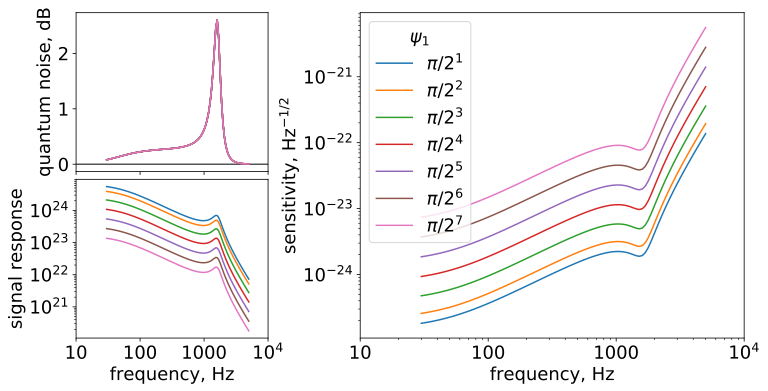

In [8]:
# squeezer produces s-i but not s-s or i-i correlations, meaning that the variational RO must be using ponderometric
# i-i correlations coupled through from s-s at the test masses which therefore should vanish with rho=0
ifo.plot_N_S_NSR_compact([
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/2, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/4, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/8, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/16, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/32, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/64, pi/2],
    [xRatio0, *(0,0,0,0), pumpPhi0, 0, pi/128, pi/2]],
    freq_tuple1, save_path='idlerRO_variational_N_S_NSR_no_RP.pdf',
    labels=[*[f'$\pi/2^{{{i}}}$' for i in np.arange(1,8)],'$\psi_1$'],
    radiation_pressure_List=np.full(8, False))

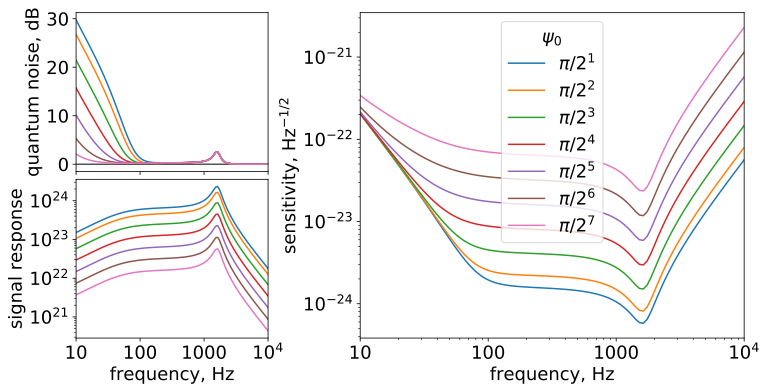

In [13]:
# signal RO, result is similar if psi0 increases to pi
ifo.plot_N_S_NSR_compact([
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/2, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/4, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/8, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/16, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/32, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/64, 0, 0],
    [xRatio0, *(0,0,0,0), pumpPhi0, pi/128, 0, 0]
], (10, 1e4, 100), save_path='signalRO_variational_N_S_NSR.pdf',
    labels=[*[f'$\pi/2^{{{i}}}$' for i in np.arange(1,8)],'$\psi_0$'])

Ponderomotive correlations

Optimal readout tolerance to decoherence from detection optical loss

In [ ]:
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
intra_losses0 = losses0[:-1]

max_Rpd = 0.8
Rpd_list = (0, 0.2, 0.4, 0.6)
Rpd_axis = np.linspace(0, max_Rpd, num=50) # increase num samples once plot works
freq_tuple = (30, 5e3, 100) #(2, 5e4, 300)
freq_list = np.logspace(np.log10(freq_tuple[0]), np.log10(freq_tuple[1]), num=freq_tuple[2])

In [ ]:
# replicating fig4 for optimal readout
for Rpd in Rpd_list:
    ifo.save_optimal_filter(freq_tuple, (*losses0[:-1],  Rpd),
                            'realistic_intras_{:.0f}%_detection'.format(Rpd),  max_iter=20)

def optimal_dBsensList_probe_vs_Rpd(probe_freq, xRatio=xRatio0):
    global _sens_for_Rpd
    def _sens_for_Rpd(Rpd):
        return ifo.optimal_sens_given_freq(probe_freq, xRatio, (*intra_losses0, Rpd))
        
    return 20*np.log10(p_map(_sens_for_Rpd, Rpd_axis)/_sens_for_Rpd(0))

freq_peak_detection_loss_0 = freq_list[opt_detection_loss_0[:,5].argmin()]
np.save('optimal_angles/optimal_dBsensList.npy', optimal_dBsensList_probe_vs_Rpd(freq_peak_detection_loss_0))

In [ ]:
# fig 5.3: tolerance of optimal readout
# --> how to compare to conventional if the idler readout rate is changing? comparison would be misleading?
# NB: these optimal filters use 0.95 threshold compared to fig4 which uses 0.986

plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

# optimal filter decoherence with detection loss --> peaks don't move, so can use hack in 2nd panel
common_path = 'optimal_angles/data_optimal_(freq,angles_complex,sens)--realistic_intras_'
linestyles1 = ['-','--','--','--']
c_list_red = [(1,0,0,1),(1,0,0,0.75),(1,0,0,0.5),(1,0,0,0.25)] # alt. use cm.Reds?

for i, Rpd in enumerate(Rpd_list):
    opt_detection_loss = np.load(common_path+'{:.0f}%_detection.npy'.format(100*Rpd))
    ax1.loglog(opt_detection_loss[:,0], opt_detection_loss[:,-1], linestyles1[i], color=c_list_red[i])
    # Q: is the reduced tolerance at the signalRO peak due to the sensitivity of the correlations?
    # to-do: test by plotting fixed signalRO for the same losses, see if the curves converge

# conventional detector curves (no squeezing, signalRO) for same parameters (e.g. idler open)    
paramsList = [*([0, *intra_losses0, Rpd, *signalRO] for Rpd in Rpd_list)]
c_list_blue = [(0,0,1,1),(0,0,1,0.75),(0,0,1,0.5),(0,0,1,0.25)]
freq_tuple1 = (1e3, 1e4, 200)
freq_list1 = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])
for i, params in enumerate(paramsList):
    ax1.loglog(freq_list1, ifo.sensList_vs_freq([*params], freq_tuple1), linestyles1[i], color=c_list_blue[i])

ax1.set_xlabel('frequency, Hz')
ax1.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
ax1.set_xlim((freq_tuple[0], freq_tuple1[1]))
ax1.set_ylim((None, 1e-23))
ax1.set_xticks([1e2, 1e3, 1e4])
ax1.set_xticklabels(['100', '1000', '$10^4$'])
ax1.legend([0, 20, 40, 60], title='detection loss, %', handlelength=1.15, ncol=1, columnspacing=1)

# horizontal lines at peaks
opt_detection_loss_0 = np.load(common_path+'0%_detection.npy')
hline_width = 1.5
# could minimise to find peak frequency, but this is close enough
freq_peak_detection_loss_0 = freq_list[opt_detection_loss_0[:,5].argmin()]
sens_peak_detection_loss_0 = opt_detection_loss_0[:,5].min()
ax1.hlines(sens_peak_detection_loss_0,
           freq_peak_detection_loss_0/hline_width,
           freq_peak_detection_loss_0*hline_width, colors='k')
ax1.hlines(ifo.ASDSh(5e3, 0, *intra_losses0, 0, *signalRO),
           5e3/hline_width,
           5e3*hline_width, colors='k') # see Fig4 generation for minimisation, shortcutting here

# tolerance metric
dBsens_list = np.load('optimal_angles/optimal_dBsensList.npy')

from matplotlib import cm
from matplotlib.colors import ListedColormap

# overlaping line segments mean that alpha tricks are inadvisable
cmp_red = ListedColormap(np.column_stack((np.ones(256), np.linspace(0, 1, 256), np.linspace(0, 1, 256), np.ones(256)))) # RGBA
# cmp_green = ListedColormap(np.column_stack((np.linspace(0, 1, 256), np.ones(256), np.linspace(0, 1, 256), np.ones(256))))
cmp_blue = ListedColormap(np.column_stack((np.linspace(0, 1, 256), np.linspace(0, 1, 256), np.ones(256), np.ones(256))))
plot_coloured_line_segments(Rpd_axis, dBsens_list, Rpd_axis/max_Rpd, cmp_red, ax=ax2)

# load and plot conv. tolerance
def _dBsensList_probe_vs_Rpd(lossless_peak_freq, xRatio, extSqzFactor): 
    global _sens_for_Rpd
    def _sens_for_Rpd(Rpd):
        return ifo.ASDSh(lossless_peak_freq, xRatio, *intra_losses0, Rpd, *signalRO, extSqzFactor=extSqzFactor)

    return 20*np.log10(p_map(_sens_for_Rpd, Rpd_axis)/_sens_for_Rpd(0))

plot_coloured_line_segments(Rpd_axis, _dBsensList_probe_vs_Rpd(5e3, 0, 1), Rpd_axis/max_Rpd, cmp_blue, ax=ax2)
# onion_data = np.load('data_of_tolerance_to_detection_loss/tolerance_(Rpd,conv,ext,nIS,ext+nIS).npy')
# plot_coloured_line_segments(onion_data[:,0], onion_data[:,1], onion_data[:,0]/max(onion_data[:,0]), cmp_blue, ax=ax2)

# ax2.scatter(Rpd_axis, dBsens_list, c=cmp_red(np.abs(Rpd_axis/np.max(Rpd_axis))), edgecolor='none', marker='.')
ax2.set_xlabel('detection loss, $\%$')
ax2.set_ylabel('reduction in peak sensitivity, dB')
ax2.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax2.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax2.set_xlim(0, max_Rpd)
ax2.set_ylim(0, 7.5)

import matplotlib.lines as mlines
blue_marker = mlines.Line2D([], [], color='b', label='no squeezing')
red_marker = mlines.Line2D([], [], color='r', label='optimal readout')
ax2.legend(handles=[blue_marker, red_marker], handlelength=1.15)

fig.align_xlabels()
plt.show()
fig.savefig('optimalRO_tolerance_to_detection_loss.pdf', bbox_inches='tight')
plt.close(fig)

## Tolerance to detection loss

In [ ]:
# tolerance to detection loss
liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)

# intra_losses = (0,0,0)
intra_losses = losses0[:-1]

In [ ]:
# tolerance to detection loss: no sqz., external sqz., nondeg. int. sqz.
# NB: high level of squeezing not used later on
intra_losses1 = losses0[:-1]
liIFO.plot_NSR_vs_freq([
    [0,*intra_losses1,0,*signalRO],
    [0,*intra_losses1,0.3,*signalRO],
    [0,*intra_losses1,0,*signalRO],
    [0,*intra_losses1,0.3,*signalRO],
    [0.986,*intra_losses1,0,*signalRO],
    [0.986,*intra_losses1,0.3,*signalRO],
    [0.986,*intra_losses1,0,*signalRO],
    [0.986,*intra_losses1,0.3,*signalRO]], (500, 1e4, 200),
    fmt_List=['b','b--','c','c--','r','r--','m','m--'],
    labels=['none, 0%', 'none, 30%',
            'external, 0%', 'external, 30%',
            'nondeg. internal, 0%', 'nondeg. internal, 30%',
            'nondeg. internal + external, 0%', 'nondeg. internal + external, 30%',
            'squeezing, detection loss\n(with intra-cavity losses)'],
    extSqzFactor_List=[1,1,1/10,1/10,1,1,1/10,1/10], figsize=(8,6), save_path='nIS_tolerance_to_detection_loss_w_intra_losses.pdf')

In [ ]:
intra_losses1 = (0,0,0)
liIFO.plot_NSR_vs_freq([
    [0,*intra_losses1,0,*signalRO],
    [0,*intra_losses1,0.3,*signalRO],
    [0,*intra_losses1,0,*signalRO],
    [0,*intra_losses1,0.3,*signalRO],
    [0.986,*intra_losses1,0,*signalRO],
    [0.986,*intra_losses1,0.3,*signalRO]], (500, 1e4, 200),
    fmt_List=['b','b--','c','c--','r','r--'],
    labels=['none, 0%', 'none, 30%',
            'external, 0%', 'external, 30%',
            'nondeg. internal, 0%', 'nondeg. internal, 30%',
            'squeezing, detection loss\n(no intra-cavity losses)'],
    extSqzFactor_List=[1,1,1/10,1/10,1,1,1/10,1/10], figsize=(8,6), save_path='nIS_tolerance_to_detection_loss_no_intra_losses.pdf')

In [ ]:
# peak sensitivity in dB versus detection loss
from scipy.optimize import minimize
from scipy.optimize import basinhopping

num_samples = 100
max_Rpd = 0.8
Rpd_List = np.linspace(0, max_Rpd, num=num_samples)

def log_sens_given_f_singleton(f_arr, *args):
    return np.log10(liIFO.ASDSh(f_arr[0], *args, extSqzFactor=extSqzFactor1))

# global peak_sens_given_Rpd
def peak_sens_given_Rpd(Rpd, full_result=False, x0=np.random.uniform(100, 1000, 1), xRatio=xRatio0):
    # find peak
    # all intra-cavity losses are zero --> no amplification of noise (why?)
    args0 = (xRatio, *intra_losses, Rpd, *signalRO)
#     bounds0 = ((1, 1e5),)
    bounds0 = ((1e2, 1e4),)    
    
    result = minimize(log_sens_given_f_singleton, x0, args=args0, bounds=bounds0, options={'maxiter': 10})

#     minimizer_kwargs = dict(args=args0, bounds=bounds0, method="L-BFGS-B")
#     result = basinhopping(log_sens_given_f_singleton, x0, minimizer_kwargs=minimizer_kwargs)   
    
    peak_sens = 10**result.fun # undo log10
    if full_result: 
        return result
    else:
        return peak_sens

def sens_List_given_x0(x0):#, no_dB=True):
    """lossless means w/o Rpd, but with other realistic losses"""
    no_det_loss_result = peak_sens_given_Rpd(0, full_result=True, x0=x0, xRatio=xRatio1)
    global no_det_loss_freq
    no_det_loss_freq = (no_det_loss_result.x)[0]
    global no_det_loss_peak
    no_det_loss_peak = 10**no_det_loss_result.fun    

    #if no_dB:
    global _peak_sens
    def _peak_sens(Rpd):
        return peak_sens_given_Rpd(Rpd, x0=no_det_loss_freq, xRatio=xRatio1)
    
    with Pool() as pool:
        return pool.map(_peak_sens, Rpd_List)

In [ ]:
# peak sens vs Rpd
# no sqz
xRatio1 = 0
extSqzFactor1 = 1
sens_List_no_sqz = sens_List_given_x0([5000])
dBsens_List_no_sqz = 20*np.log10(sens_List_no_sqz/no_det_loss_peak)

# ext sqz
xRatio1 = 0
extSqzFactor1 = 1/10
sens_List_ext_sqz = sens_List_given_x0([5000])
dBsens_List_ext_sqz = 20*np.log10(sens_List_ext_sqz/no_det_loss_peak)

# nIS
xRatio1 = 0.986
extSqzFactor1 = 1
sens_List = sens_List_given_x0([1600])
dBsens_List = 20*np.log10(sens_List/no_det_loss_peak)

# nIS + ext sqz
xRatio1 = 0.986
extSqzFactor1 = 1/10
sens_List_nIS_and_ext_sqz = sens_List_given_x0([1600])
dBsens_List_nIS_and_ext_sqz = 20*np.log10(sens_List_nIS_and_ext_sqz/no_det_loss_peak)

In [ ]:
np.save('data_of_tolerance_to_detection_loss/nIS_Rpd_List.npy', Rpd_List)
np.save('data_of_tolerance_to_detection_loss/nIS_dBsens_List_no_sqz.npy', dBsens_List_no_sqz)
np.save('data_of_tolerance_to_detection_loss/nIS_dBsens_List_ext_sqz.npy', dBsens_List_ext_sqz)
np.save('data_of_tolerance_to_detection_loss/nIS_dBsens_List.npy', dBsens_List)
np.save('data_of_tolerance_to_detection_loss/nIS_dBsens_List_nIS_and_ext_sqz.npy', dBsens_List_nIS_and_ext_sqz)

In [ ]:
# plotting
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Rpd_List, sens_List_no_sqz, 'b-', label='no sqz.')
ax.plot(Rpd_List, sens_List_ext_sqz, 'c-', label='ext. sqz. (ES)')
ax.plot(Rpd_List, sens_List, 'r-', label='ND int. sqz. (nIS)')
ax.plot(Rpd_List, sens_List_nIS_and_ext_sqz, 'm-', label='nIS and ES')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity (NSR) / $\mathrm{Hz}^{-1/2}$')
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_yscale('log')
ax.legend()
plt.show()
# fig.savefig('peak_sens_vs_detection_loss_no_dB_no_intra-cavity_losses.pdf', bbox_inches = "tight")
fig.savefig('peak_sens_vs_detection_loss_no_dB_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Rpd_List, dBsens_List_no_sqz, 'b-', label='no sqz.')
ax.plot(Rpd_List, dBsens_List_ext_sqz, 'c-', label='ext. sqz. (ES)')
ax.plot(Rpd_List, dBsens_List, 'r-', label='ND int. sqz. (nIS)')
ax.plot(Rpd_List, dBsens_List_nIS_and_ext_sqz, 'm-', label='nIS and ES')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity (NSR) / dB')
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_ylim(0, None)
ax.legend()
plt.rcParams.update({'font.size': 18})
plt.show()
# fig.savefig('peak_sens_vs_detection_loss_no_intra-cavity_losses.pdf', bbox_inches = "tight")
fig.savefig('peak_sens_vs_detection_loss_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

Same process for degenerate internal squeezing

In [ ]:
# dIS tolerance to detection loss
dIS_ifo =  IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*5000, 0)
# dIS_intra_losses = (0,0)
dIS_intra_losses = losses0[:2]

In [ ]:
# intra losses are zero
dIS_intra_losses1 = dIS_intra_losses
dIS_ifo.dIS_plot_NSR_vs_freq([
    [0,*dIS_intra_losses1,0,pi/2],
    [0,*dIS_intra_losses1,0.3,pi/2],
    [0,*dIS_intra_losses1,0,pi/2],
    [0,*dIS_intra_losses1,0.3,pi/2],
    [0.95,*dIS_intra_losses1,0,pi/2],
    [0.95,*dIS_intra_losses1,0.3,pi/2],
    [0.95,*dIS_intra_losses1,0,pi/2],
    [0.95,*dIS_intra_losses1,0.3,pi/2]],(2, 5e4, 200),
    fmt_List=['b','b--','c','c--','r','r--','m','m--'],
    labels=['none, 0%', 'none, 30%',
            'external, 0%', 'external, 30%',
            'deg. internal, 0%', 'deg. internal, 30%',
            'deg. internal + external, 0%', 'deg. internal + external, 30%',
            'squeezing, detection loss\n(no intra-cavity losses)'],
    extSqzFactor_List=[1,1,1/10,1/10,1,1,1/10,1/10], figsize=(8,6), save_path='dIS_tolerance_to_detection_loss_no_intra_losses.pdf',
    show_legend=True, legend_size=12)

In [ ]:
# with realistic intra-cavity losses
dIS_intra_losses1 = losses0[:2]
dIS_ifo.dIS_plot_NSR_vs_freq([
    [0,*dIS_intra_losses1,0,pi/2],
    [0,*dIS_intra_losses1,0.3,pi/2],
    [0,*dIS_intra_losses1,0,pi/2],
    [0,*dIS_intra_losses1,0.3,pi/2],
    [0.95,*dIS_intra_losses1,0,pi/2],
    [0.95,*dIS_intra_losses1,0.3,pi/2]],(1e2, 1e4, 200),
    fmt_List=['b','b--','c','c--','r','r--'],
    labels=['none, 0%', 'none, 30%',
            'external, 0%', 'external, 30%',
            'deg. internal, 0%', 'deg. internal, 30%',
            'squeezing, detection loss\n(realistic intra-cavity losses)'],
    extSqzFactor_List=[1,1,1/10,1/10,1,1,1/10,1/10], figsize=(8,6),
    save_path='dIS_tolerance_to_detection_loss_w_intra_losses.pdf',
    show_legend=True)

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
    
# make sure that it is the same as nIS axis
num_samples = 200
max_Rpd = 0.8
Rpd_List = np.linspace(0, max_Rpd, num=num_samples)

def dIS_log_sens_given_f_singleton(f_arr, *args):
    return np.log10(dIS_ifo.dIS_ASDSh(f_arr[0], *args, extSqzFactor=extSqzFactor1))

def dIS_peak_sens_given_Rpd(Rpd, full_result=False, x0=np.random.uniform(100, 1000, 1), xRatio=xRatio0):
    # all other losses are zero
    args0 = (xRatio, *dIS_intra_losses, Rpd, pi/2)
#     bounds0 = ((1, 1e5),)
    bounds0 = ((1e2, 1e4),)    
#     result = minimize(dIS_log_sens_given_f_singleton, x0, args=args0, bounds=bounds0, options={'maxiter':1000})
    result = basinhopping(dIS_log_sens_given_f_singleton, x0, minimizer_kwargs={'args':args0})
    peak_sens = 10**result.fun 
    if full_result: 
        return result
    else:
        return peak_sens

def dIS_sens_List_given_x0(x0):
    """lossless means w/o Rpd, but with other realistic losses"""
    no_det_loss_result = dIS_peak_sens_given_Rpd(0, full_result=True, x0=x0, xRatio=xRatio1)
    global no_det_loss_freq
    no_det_loss_freq = (no_det_loss_result.x)[0]
    global no_det_loss_peak
    no_det_loss_peak = 10**no_det_loss_result.fun    
    global _peak_sens
    def _peak_sens(Rpd):
        return dIS_peak_sens_given_Rpd(Rpd, x0=no_det_loss_freq, xRatio=xRatio1)
    
    with Pool() as pool:
        return np.array(pool.map(_peak_sens, Rpd_List))

In [ ]:
# no sqz
xRatio1 = 0
extSqzFactor1 = 1
dIS_sens_List_no_sqz = dIS_sens_List_given_x0([5000])
dIS_dBsens_List_no_sqz = 20*np.log10(dIS_sens_List_no_sqz/no_det_loss_peak)

# ext sqz
xRatio1 = 0
extSqzFactor1 = 1/10
dIS_sens_List_ext_sqz = dIS_sens_List_given_x0([5000])
dIS_dBsens_List_ext_sqz = 20*np.log10(dIS_sens_List_ext_sqz/no_det_loss_peak)

# dIS
xRatio1 = xRatio0 
extSqzFactor1 = 1
dIS_sens_List = dIS_sens_List_given_x0([5000])
dIS_dBsens_List = 20*np.log10(dIS_sens_List/no_det_loss_peak)

# dIS + ext sqz
xRatio1 = xRatio0
extSqzFactor1 = 1/10
dIS_sens_List_dIS_and_ext_sqz = dIS_sens_List_given_x0([5000])
dIS_dBsens_List_dIS_and_ext_sqz = 20*np.log10(dIS_sens_List_dIS_and_ext_sqz/no_det_loss_peak)

In [ ]:
np.save('data_of_tolerance_to_detection_loss/dIS_Rpd_List.npy', Rpd_List)
np.save('data_of_tolerance_to_detection_loss/dIS_dBsens_List_no_sqz.npy', dIS_dBsens_List_no_sqz)
np.save('data_of_tolerance_to_detection_loss/dIS_dBsens_List_ext_sqz.npy', dIS_dBsens_List_ext_sqz)
np.save('data_of_tolerance_to_detection_loss/dIS_dBsens_List.npy', dIS_dBsens_List)
np.save('data_of_tolerance_to_detection_loss/dIS_dBsens_List_dIS_and_ext_sqz.npy', dIS_dBsens_List_dIS_and_ext_sqz)

In [ ]:
# plotting
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Rpd_List, dIS_sens_List_no_sqz, 'b-', label='no sqz.')
ax.plot(Rpd_List, dIS_sens_List_ext_sqz, 'c-', label='ext. sqz. (ES)')
ax.plot(Rpd_List, dIS_sens_List, 'r-', label='deg. int. sqz. (dIS)')
ax.plot(Rpd_List, dIS_sens_List_dIS_and_ext_sqz, 'm-', label='dIS and ES')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity (NSR) / $\mathrm{Hz}^{-1/2}$')
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_yscale('log')
ax.legend()
plt.show()
# fig.savefig('dIS_peak_sens_vs_detection_loss_no_dB_no_intra-cavity_losses.pdf', bbox_inches = "tight")
fig.savefig('dIS_peak_sens_vs_detection_loss_no_dB_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Rpd_List, dIS_dBsens_List_no_sqz, 'b-', label='no sqz.')
ax.plot(Rpd_List, dIS_dBsens_List_ext_sqz, 'c-', label='ext. sqz. (ES)')
ax.plot(Rpd_List, dIS_dBsens_List, 'r-', label='deg. int. sqz. (dIS)')
ax.plot(Rpd_List, dIS_dBsens_List_dIS_and_ext_sqz, 'm-', label='dIS and ES')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity (NSR) / dB')
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_ylim(0, None)
ax.legend()
plt.rcParams.update({'font.size': 18})
plt.show()
# fig.savefig('dIS_peak_sens_vs_detection_loss_no_intra-cavity_losses.pdf', bbox_inches = "tight")
fig.savefig('dIS_peak_sens_vs_detection_loss_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

In [ ]:
nIS_Rpd_List = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/nIS_Rpd_List.npy')
nIS_dBsens_List_no_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/nIS_dBsens_List_no_sqz.npy')
nIS_dBsens_List_ext_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/nIS_dBsens_List_ext_sqz.npy')
nIS_dBsens_List = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/nIS_dBsens_List.npy')
nIS_dBsens_List_nIS_and_ext_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/nIS_dBsens_List_nIS_and_ext_sqz.npy')

dIS_Rpd_List = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/dIS_Rpd_List.npy')
dIS_dBsens_List_no_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/dIS_dBsens_List_no_sqz.npy')
dIS_dBsens_List_ext_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/dIS_dBsens_List_ext_sqz.npy')
dIS_dBsens_List = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/dIS_dBsens_List.npy')
dIS_dBsens_List_dIS_and_ext_sqz = np.load('data_of_tolerance_to_detection_loss/realistic_intra-cavity_losses/dIS_dBsens_List_dIS_and_ext_sqz.npy')

In [ ]:
# all squeezing configurations, tolerance to detection loss
# print(intra_losses, dIS_intra_losses)
fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(Rpd_List, dBsens_List_nIS_and_ext_sqz, 'm-', label='nIS + ES')
ax.plot(dIS_Rpd_List, dIS_dBsens_List, 'g-', label='deg. internal')
ax.plot(dIS_Rpd_List, dIS_dBsens_List_dIS_and_ext_sqz, 'g--', label='deg. internal + external')
ax.plot(nIS_Rpd_List, nIS_dBsens_List_ext_sqz, 'c-', label='external') # to-do: check that dIS results give the same?
ax.plot(nIS_Rpd_List, nIS_dBsens_List_no_sqz, 'b-', label='none')
ax.plot(nIS_Rpd_List, nIS_dBsens_List_nIS_and_ext_sqz, 'r--', label='nondeg. internal + external')
ax.plot(nIS_Rpd_List, nIS_dBsens_List, 'r-', label='nondeg. internal')
# ax.plot(Rpd_List, dIS_dBsens_List_dIS_and_ext_sqz, 'm--', label='dIS + ES')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity (NSR) / dB')
# max_Rpd = 0.8 # update with top box
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_ylim(0, None)
ax.legend(title='squeezing')
# handles, labels = ax.get_legend_handles_labels()
# leg_order = lambda list0 : [list0[-1], list0[1], list0[0], list0[2]]
# ax.legend(leg_order(handles), leg_order(labels))
ax.set_title('realistic intra-cavity losses')
plt.rcParams.update({'font.size': 18})
plt.show()
# fig.savefig('all_sqzs_peak_sens_vs_detection_loss_no_intra-cavity_losses.pdf', bbox_inches = "tight")
fig.savefig('all_sqzs_peak_sens_vs_detection_loss_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

In [ ]:
# "onion" plot, nIS, tolerance to detection loss
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nIS_Rpd_List, nIS_dBsens_List_ext_sqz, 'c-', label='10 dB injected')
ax.plot(nIS_Rpd_List, nIS_dBsens_List_no_sqz, 'b-', label='none')
ax.plot(nIS_Rpd_List, nIS_dBsens_List_nIS_and_ext_sqz, 'm-', label='nondegenerate internal\n+ 10 dB injected')
ax.plot(nIS_Rpd_List, nIS_dBsens_List, 'r-', label='nondegenerate internal')
ax.set_xlabel('detection loss / $\%$')
ax.set_ylabel('peak sensitivity reduction / dB')
max_Rpd=0.8
ax.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax.set_xlim(0, max_Rpd)
ax.set_ylim(0, None)
ax.legend(title='squeezing')
plt.rcParams.update({'font.size': 18})
plt.show()
# fig.savefig('all_sqzs_peak_sens_vs_detection_loss_w_intra-cavity_losses.pdf', bbox_inches = "tight")
plt.close(fig)

### Combined plot for publication

In [ ]:
# combined tolerance plot
liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
intra_losses= losses0[:-1]
intra_losses1 = intra_losses

# "boring plot" tolerance to detection loss: no sqz., nondeg. int. sqz.
# looks different to s11 because of xRatio = 98.6% instead of 95%
Rpd_List1 = (0, 0.2, 0.4, 0.6)
freq_tuple1 = (2, 5e4, 300)
f_List = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])

paramsList = [
    *([0, *intra_losses1, Rpd, *signalRO] for Rpd in Rpd_List1),
    *([0.986, *intra_losses1, Rpd, *signalRO] for Rpd in Rpd_List1)]
labels1 = [*('' for _ in Rpd_List1),
           *('{:.0f}%'.format(Rpd*100) for Rpd in Rpd_List1),
            'detection loss']
linestyles1 = ['-','--','--','--','-','--','--','--']
colors1 = [(0,0,1,1),(0,0,1,0.75),(0,0,1,0.5),(0,0,1,0.25),
           (1,0,0,1),(1,0,0,0.75),(1,0,0,0.5),(1,0,0,0.25)]

sensListList = np.empty((len(paramsList), len(f_List)))
for i, params in enumerate(paramsList):
    sensListList[i] = liIFO.sensList_vs_freq([*params], freq_tuple1)

from scipy.optimize import minimize

def peak_sens_given_Rpd2(Rpd, x0=np.random.uniform(100, 1000, 1),
                         xRatio=xRatio0, extSqzFactor1=1, intra_losses1=losses0[:-1]):
    args0 = (xRatio, *intra_losses1, Rpd, *signalRO)
    bounds0 = ((1e2, 1e4),)
    
    def log_sens_given_f_singleton(f_arr, *args):
        return np.log10(liIFO.ASDSh(f_arr[0], *args, extSqzFactor=extSqzFactor1))
    
    return minimize(log_sens_given_f_singleton, x0, args=args0, bounds=bounds0, options={'maxiter': 10})    
    
lossless_peak_freq0 = peak_sens_given_Rpd2(0, x0=5e3, xRatio=0, extSqzFactor1=1, intra_losses1=intra_losses1).x[0]    
result1 = peak_sens_given_Rpd2(0, x0=2e3, xRatio=0.986, extSqzFactor1=1, intra_losses1=intra_losses1)
lossless_peak_freq1 = result1.x[0]

# probe sensitivity (at lossless peak frequency) in dB versus detection loss
num_samples = 50 # 300 points required for old scatter technique
max_Rpd = 0.8 # odd that this isn't max(Rpd_List1)
Rpd_List = np.linspace(0, max_Rpd, num=num_samples)

def dBsensList_probe_vs_Rpd(lossless_peak_freq, xRatio1, extSqzFactor1): 
    global _sens_for_Rpd
    def _sens_for_Rpd(Rpd):
        return liIFO.ASDSh(lossless_peak_freq, xRatio1, *intra_losses1, Rpd, *signalRO, extSqzFactor=extSqzFactor1)

    return 20*np.log10(p_map(_sens_for_Rpd, Rpd_List)/_sens_for_Rpd(0))

dBsensListList = np.empty((4, num_samples))
# no sqz
dBsensListList[0] = dBsensList_probe_vs_Rpd(lossless_peak_freq0, 0, 1)
# ext sqz
dBsensListList[1] = dBsensList_probe_vs_Rpd(lossless_peak_freq0, 0, 1/10)
# nIS
dBsensListList[2] = dBsensList_probe_vs_Rpd(lossless_peak_freq1, 0.986, 1)
# nIS + ext sqz
dBsensListList[3] = dBsensList_probe_vs_Rpd(lossless_peak_freq1, 0.986, 1/10)

dataset = np.empty((num_samples, 5))
dataset[:,0], dataset[:,1:] = Rpd_List, dBsensListList.transpose()
np.save('data_of_tolerance_to_detection_loss/tolerance_(Rpd,conv,ext,nIS,ext+nIS).npy', dataset)

In [ ]:
# Fig4 for paper with onion right subplots combined
plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

for i, sensList in enumerate(sensListList):
    ax1.loglog(f_List, sensList, label=labels1[i], linestyle=linestyles1[i], color=colors1[i])

ax1.legend(title=labels1[-1], handlelength=1.15)
ax1.set_xlabel('frequency, Hz')
ax1.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
ax1.set_xlim((freq_tuple1[0], freq_tuple1[1]))
ax1.set_xticks([1e1, 1e2, 1e3, 1e4])
ax1.set_xticklabels(['10', '100', '1000', '$10^4$'])

hline_width = 1.8
ax1.hlines(sensListList[0].min(),
           f_List[sensListList[0].argmin()]/hline_width,
           f_List[sensListList[0].argmin()]*hline_width, colors='k') #log(peak*2^(+-1)) = log(peak) +- log(2)
ax1.hlines(sensListList[4].min(),
           f_List[sensListList[4].argmin()]/hline_width,
           f_List[sensListList[4].argmin()]*hline_width, colors='k')

from matplotlib import cm
from matplotlib.colors import ListedColormap

N = 256
cmp_blue = ListedColormap(np.column_stack((np.linspace(0, 1, N), np.linspace(0, 1, N), np.ones(N), np.ones(N))))
cmp_red = ListedColormap(np.column_stack((np.ones(N), np.linspace(0, 1, N), np.linspace(0, 1, N), np.ones(N))))

plot_coloured_line_segments(Rpd_List, dBsensListList[0], np.abs(Rpd_List/np.max(Rpd_List)), cmp_blue, ax=ax2)
plot_coloured_line_segments(Rpd_List, dBsensListList[2], np.abs(Rpd_List/np.max(Rpd_List)), cmp_red, ax=ax2)
# ax2.scatter(Rpd_List, dBsensListList[0], c=cmp_blue(np.abs(Rpd_List/np.max(Rpd_List))),
#            edgecolor='none', marker='.')
# ax2.scatter(Rpd_List, dBsensListList[2], c=cmp_red(np.abs(Rpd_List/np.max(Rpd_List))),
#            edgecolor='none', marker='.')
ax2.set_xlabel('detection loss, $\%$')
# ax2.set_title('sensitivity compared to\n0% detection loss peak / dB', fontsize=18)
ax2.set_ylabel('reduction in peak sensitivity, dB')
ax2.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax2.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax2.set_xlim(0, max_Rpd)
ax2.set_ylim(0, 7.5)

import matplotlib.lines as mlines
blue_marker = mlines.Line2D([], [], color='b', label='no squeezing')
red_marker = mlines.Line2D([], [], color='r', label='nondegenerate\ninternal squeezing')
ax2.legend(handles=[blue_marker, red_marker], handlelength=1.15)

fig.align_xlabels()
plt.show()
fig.savefig('nIS_tolerance_to_detection_loss_sens_reduction_combined.pdf', bbox_inches='tight')
plt.close(fig)

In [ ]:
# split onion plots
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(11, 6))

gs = fig.add_gridspec(2, 2, wspace=0.18, hspace=0.05)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

for i, sensList in enumerate(sensListList):
    ax1.loglog(f_List, sensList, label=labels1[i], linestyle=linestyles1[i], color=colors1[i])

ax1.legend(title=labels1[-1], handlelength=1.15)
ax1.set_xlabel('frequency, Hz')
ax1.set_ylabel('sensitivity, $\mathrm{Hz}^{-1/2}$')
ax1.set_xlim((freq_tuple1[0], freq_tuple1[1]))
ax1.set_xticks([1e1, 1e2, 1e3, 1e4])
ax1.set_xticklabels(['10', '100', '1000', '$10^4$'])

from matplotlib import cm
from matplotlib.colors import ListedColormap

N = 256
vals = np.zeros((N, 4))
vals[:, 0] = np.linspace(0, 1, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.ones(N)
vals[:, 3] = np.ones(N)
cmp_blue = ListedColormap(vals)
vals = np.zeros((N, 4))
vals[:, 0] = np.ones(N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
vals[:, 3] = np.ones(N)
cmp_red = ListedColormap(vals)

ax2.scatter(Rpd_List, dBsensListList[0], c=cmp_blue(np.abs(Rpd_List/np.max(Rpd_List))),
           edgecolor='none', marker='.')
ax3.scatter(Rpd_List, dBsensListList[2], c=cmp_red(np.abs(Rpd_List/np.max(Rpd_List))),
           edgecolor='none', marker='.')
ax3.set_xlabel('detection loss, $\%$')
# ax2.set_title('sensitivity compared to\n0% detection loss peak / dB', fontsize=18)
ax2.set_ylabel('reduction in peak sensitivity, dB')
ax2.yaxis.set_label_coords(-0.08, 0)
ax3.set_xticks(np.arange(0, max_Rpd+0.2, step=0.2))
ax2.set_xticklabels([])
ax3.set_xticklabels(('{:.0f}'.format(i) for i in np.arange(0, 100*(max_Rpd+0.2), step=20)))
ax2.set_xlim(0, max_Rpd)
ax3.set_xlim(0, max_Rpd)
ax2.set_ylim(0, 7.5)
ax3.set_ylim(0, 7.5)

import matplotlib.lines as mlines
blue_marker = mlines.Line2D([], [], color='b', label='no squeezing')
red_marker = mlines.Line2D([], [], color='r', label='nondegenerate internal\nsqueezing')
ax2.legend(handles=[blue_marker], handlelength=1.15)
ax3.legend(handles=[red_marker], handlelength=1.15)

fig.align_xlabels()
plt.show()
fig.savefig('nIS_tolerance_to_detection_loss_sens_reduction_split.pdf', bbox_inches='tight')
plt.close(fig)

## Experimenting with CE and ET parameter sets

In [ ]:
# experimenting with CE and ET parameter sets
# IFO(lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None)
aLIGO = IFO(1064e-9, 4e3, 56, 750e3, 0.014, 0.325, 40, None, None, 0) # to turn idler readout off
Voyager = IFO(2e-6, 4e3, 56,  3e6, 0.002, 0.046, 200, None, None, 0)
liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
CE40km = IFO(1064e-9, 40e3, 55, 1.5e6, 0.014, 0.02, 320, None, None, 0) 
ETHF =   IFO(1064e-9, 10e3, 310, 3e6, 7000e-6, 0.1, 200, None, None, 0)
CE_T2000017 = np.loadtxt("ce_strain.txt")
# Voyager.print_params()
# liIFO.print_params()

In [ ]:
# comparing IFOs, no squeezing (internal or external), realistic losses, signal readout
IFO_list = (aLIGO, Voyager, liIFO, CE40km, ETHF)
ifo_labels = ("Adv. LIGO", "Voyager", "Li et al. 2020", "CE-40km", "ET-HF")

freq_tuple1 = (1, 1e5, 200)
f_List = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()

for i, ifo in enumerate(IFO_list):
    ax.loglog(f_List, ifo.sensList_vs_freq([0, *losses0, *signalRO], freq_tuple1), label=ifo_labels[i])

# with Pool() as pool:
#     ax.loglog(f_List, pool.map(SQL, f_List), 'k', label='SQL')   
    
# ax.loglog(CE_T2000017[:,0], CE_T2000017[:,1], 'r--', label='CE-40km - total noise (T2000017)')    
ax.legend()
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
plt.show()
fig.savefig('all_ifos.pdf', bbox_inches="tight")

In [ ]:
# by Fig7.1 in CE Design Doc., expect 40kmCB to achieve 2e-25 peak and have a small feature at 3-4kHz at 1e-24
# 2e-25 is only achieved by 10 dB inj. in the lossless case, the kHz feature is also missing
# what is wrong? (also, QRPN  is louder in plot --> might include other noises? e.g. thermal?)
# Fig. 8.2 for noise budget, QN still shows kHz feature and less than 1e-24 at 5Hz
# --> feature could be coupled-cavity pole, if ws was 4kHz and gbR Order(10)kHz
CE40km.print_params()
# using Table8.1 losses

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8,6))
freq_tuple1 = (5, 5e3, 200)
f_List = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])
ax.loglog(f_List, CE40km.sensList_vs_freq([0, *(40e-6, 500e-6, 500e-6, 0.1), *signalRO], freq_tuple1, extSqzFactor=1/10), label="QN only, lossy (Table 8.1) + 10 dB inj.")
ax.loglog(f_List, CE40km.sensList_vs_freq([0, *(0, 0, 0, 0), *signalRO], freq_tuple1, extSqzFactor=1/10), label= "QN only, lossless + 10 dB inj.")
ax.loglog(CE_T2000017[:,0], CE_T2000017[:,1], '--', label='CE-40km - total noise (T2000017)')       
ax.loglog(f_List, CE40km.sensList_vs_freq([0, *(40e-6, 500e-6, 500e-6, 0), *signalRO], freq_tuple1, extSqzFactor=1/10), label="QN only, lossy (no detection loss) + 10 dB inj.")
ax.legend(title="CE-40km (CB)")
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
ax.set_xlim((freq_tuple1[0], freq_tuple1[1]))
plt.show()
fig.savefig('CE_with_official.pdf', bbox_inches="tight")
# CE40km.plot_NSR_vs_freq([
#     [0, *(40e-6, 500e-6, 500e-6, 0.1), *signalRO],
#     [0, *(0,0,0,0), *signalRO]], (5, 5e3, 200), labels=["lossy (Table 8.1) + 10 dB inj.", "lossless + 10 dB inj.", "CE-40km (CB)"],
#     extSqzFactor_List=[1/10, 1/10], save_path='CE40km.pdf')

In [ ]:
arm_lengths = (4e3, 10e3, 40e3, 100e3)
ifo_labels = ("4", "10", "40", "100", "CE\narm length / km")

freq_tuple1 = (5, 5e4, 100)
f_List = np.logspace(np.log10(freq_tuple1[0]), np.log10(freq_tuple1[1]), num=freq_tuple1[2])

fig, ax = plt.subplots()
for i, arm in enumerate(arm_lengths):
#     CE40km = IFO(1064e-9, 40e3, 55, 1.5e6, 0.014, 0.02, 320, None, None, 0) 
    ifo = IFO(1064e-9, arm, 55, 1.5e6, 0.014, 0.02, 320, None, None, 0)
    ifo.print_params()
    ax.loglog(f_List, ifo.sensList_vs_freq([0, *(40e-6, 500e-6, 500e-6, 0.1), *signalRO], freq_tuple1),
              label=ifo_labels[i])

ax.loglog(CE_T2000017[:,0], CE_T2000017[:,1], '--', label='CE-40km - total noise (T2000017)')       
ax.legend(title=ifo_labels[-1])
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
plt.show()
fig.savefig('CE_varying_arm_length.pdf', bbox_inches="tight")

In [ ]:
# ET Fig.1.10 shows 3e-25 peak (total noise) for ET-HF and no features at kHz
# uses 10dB (effective*) freq.dep.inj.ext.sqz., *meaning output is reduced by 10dB?
#            to-do: look at QN to get correct extsqzfactor to achieve this
# with 10dB injected (not effective), the lossy case meets 3e-25
# ET Fig. 1.13 shows noise budget: QN-limited achieves 2e-25 and less than 1e-23 at 10 Hz, but is less than 6e-24 at 1e4 Hz
# --> something wrong with the signal transfer function roll-off being too fast for my plot
ETHF.print_params()
ETHF.plot_NSR_vs_freq([
    [0, *(40e-6, 500e-6, 500e-6, 0.1), *signalRO],
    [0, *(0,0,0,0), *signalRO],
    [0, *(40e-6, 500e-6, 500e-6, 0.1), *signalRO],
    [0, *(0,0,0,0), *signalRO]], (5, 5e3, 200), labels=["lossy (Table 8.1)", "lossless", "lossy + 10 dB inj.", "lossless + 10 dB inj.", "ET-HF"],
    extSqzFactor_List=[1, 1, 1/10, 1/10], fmt_List=['b-','c-','b--','c--'], save_path='ET-HF.pdf')

In [ ]:
# checking if single-mode approximation indeed misses arm cavity FSR (also blind to Michelson notch)
aLIGO.plot_N_S_NSR([
    [0, *losses0, *signalRO],
    [0, *(0,0,0,0), *signalRO]], (1, 1e5, 200), labels=['lossy', 'lossless', 'aLIGO'],
    save_path='aLIGO_to_1e5Hz.pdf')

In [ ]:
# compile ASDSh? http://numba.pydata.org/numba-doc/0.17.0/user/jit.html
# @jit(nopython=True, cache=True)

# Google's python cloud cores?